In [1]:
%matplotlib inline

import os
os.chdir('/Users/Tony/Documents/Git Folder/seelviz/Jupyter/DownsampleGraphML')

from argparse import ArgumentParser
from collections import OrderedDict
from subprocess import Popen
from scipy.stats import gaussian_kde
from matplotlib.backends.backend_pdf import PdfPages

import numpy as np
import nibabel as nb
import networkx as nx
import os
import pickle
import matplotlib.pyplot as plt

In [2]:
# Change the filename below to run different graphml files
filename = 'Fear199localeq.5000.graphml'
G = nx.read_graphml(filename)

In [3]:
def scan_statistic(G, i):
    """
    Computes scan statistic-i on a set of graphs

    Required Parameters:
        G: graph
        i:
            - which scan statistic to compute
    """
    tmp = np.array(())
    for n in G.nodes():
        sg = nx.ego_graph(G, n, radius=i)
        tmp = np.append(tmp, np.sum([sg.get_edge_data(e[0], e[1])['weight']
                        for e in sg.edges()]))
        ss = tmp
    return ss

In [4]:
def density(data):
    """
    Computes density for metrics which return vectors

    Required parameters:
        data:
            - Dictionary of the vectors of data
    """
    dens = gaussian_kde(data)
    xs = np.linspace(0, 1.2*np.max(data), 1000)
    density = dens.pdf(xs)

    return {"xs": xs, "pdfs": density}

In [5]:
def write(outdir, metric, data, atlas):
    """
    Write computed derivative to disk in a pickle file
    Required parameters:
        outdir:
            - Path to derivative save location
        metric:
            - The value that was calculated
        data:
            - The results of this calculation
        atlas:
            - Name of atlas of interest as it appears in the directory titles
    """
    of = open(outdir + '/' + atlas + '_' + metric + '.pkl', 'wb')
    pickle.dump({metric: data}, of)
    of.close()

In [6]:
# NNZ - Number of non-zero edges
print len(nx.edges(G))
write('../pickels', 'non-zero_edges', nx.edges(G), filename)

18665


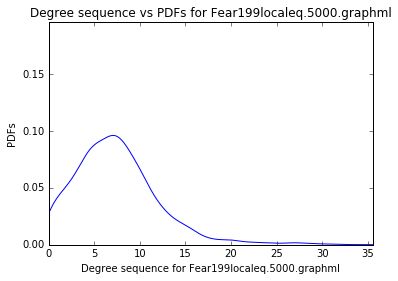

In [7]:
# Degree sequence
temp_deg = np.array(nx.degree(G).values())
deg = density(temp_deg)
# print deg
xs = deg['xs']
pdfs = deg['pdfs']

# Autoscale Output Image
pdfs = [i for i in pdfs if i >= 0.0001]
xs = xs[0: len(pdfs)]
xsMAX = np.amax(xs)
pdfsMAX = np.amax(pdfs)

# Plot File
plt.axis([0, xsMAX + 0.001, 0, pdfsMAX + 0.1])
plt.xlabel('Degree sequence for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Degree sequence vs PDFs for ' + filename)
fig1 = plt.plot(xs, pdfs)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'degreesequence.png', bbox_inches='tight')

# Make pickel
write('../pickels', 'degree sequence', deg, filename)

In [8]:
# Compute Edge Weight 
temp_ew = (G.get_edge_data(e[0], e[1])['weight'] for e in G.edges())
## ew = density(temp_ew) "ValueError: `dataset` input should have multiple elements."
print temp_ew
# We don't have edge weights so this makes sense

# Make pickel
# write('../pickels', 'edge weight', temp_ew, filename)

<generator object <genexpr> at 0x1121e2870>


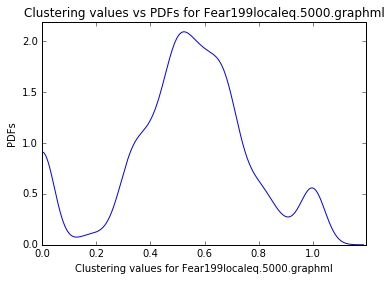

In [9]:
# Clustering Coefficients
nxc = nx.clustering 
temp_cc = nxc(G).values()
ccoefs = density(temp_cc)
xscc = ccoefs['xs']
pdfscc = ccoefs['pdfs']

# Autoscale Output Image
pdfscc = [i for i in pdfscc if i >= 0.0001]
xscc = xscc[0: len(pdfscc)]
xsccMAX = np.amax(xscc)
pdfsccMAX = np.amax(pdfscc)


# Plot File
plt.axis([0, xsccMAX + 0.01, 0, (pdfsccMAX + 0.1)])
plt.xlabel('Clustering values for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Clustering values vs PDFs for ' + filename)
fig2 = plt.plot(xscc, pdfscc)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename +'clusteringcoefficients.png', bbox_inches='tight')

# Make pickel
write('../pickels', 'clustering coefficient', ccoefs, filename)

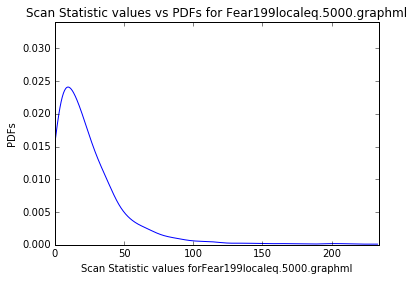

In [10]:
# Scan Statistic-1 
temp_ss1 = scan_statistic(G, 1)
ss1 = density(temp_ss1)

xsss = ss1['xs']
pdfsss = ss1['pdfs']

# Autoscale Output Image
pdfsss = [i for i in pdfsss if i >= 0.0001]
xsss = xsss[0: len(pdfsss)]
xsssMAX = np.amax(xsss)
pdfsssMAX = np.amax(pdfsss)

plt.axis([0, xsssMAX + 1, 0, pdfsssMAX + 0.01])
plt.xlabel('Scan Statistic values for' + filename)
plt.ylabel('PDFs')
plt.title(r'Scan Statistic values vs PDFs for ' + filename)
fig3 = plt.plot(xsss, pdfsss)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'scanstatistic.png')

# Make pickel
write('../pickels', 'scan statistic-1', ss1, filename)

/Users/Tony/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:589: ComplexWarning: Casting complex values to real discards the imaginary part
  tmp_a_data = tmp_a.astype(float)
/Users/Tony/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:595: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = tmp_a.astype(np.intp)
/Users/Tony/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:641: ComplexWarning: Casting complex values to real discards the imaginary part
  self._x = float(xy[0])
/Users/Tony/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:643: ComplexWarning: Casting complex values to real discards the imaginary part
  self._width = float(width)


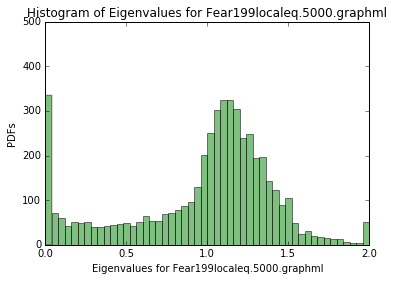

In [11]:
# EigenValues 
laplacian = nx.normalized_laplacian_matrix(G)
eigs = np.sort(np.linalg.eigvals(laplacian.A))[::-1]

num_bins = 50
# the histogram of the data
n, bins, patches = plt.hist(eigs, num_bins, facecolor='green', alpha=0.5)

plt.axis([0, 2, 0, 500])
plt.xlabel('Eigenvalues for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Histogram of Eigenvalues for ' + filename)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'eigenvalues.png')

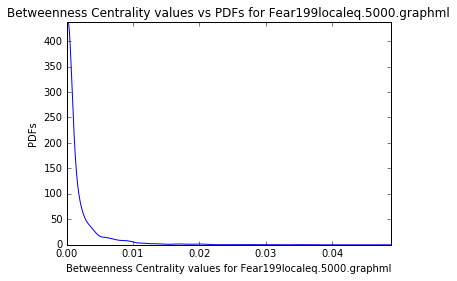

In [12]:
#Betweenness Centrality
nxbc = nx.algorithms.betweenness_centrality
temp_bc = (nxbc(G).values())
centrality = density(temp_bc)

xsbetween = centrality['xs']
pdfsbetween = centrality['pdfs']

# Autoscale Output Image
pdfsbetween = [i for i in pdfsbetween if i >= 0.0001]
xsbetween = xsbetween[0: len(pdfsbetween)]
xsbetweenMAX = np.amax(xsbetween)
pdfsbetweenMAX = np.amax(pdfsbetween)

# Plot
plt.axis([0, xsbetweenMAX, 0, pdfsbetweenMAX])
plt.xlabel('Betweenness Centrality values for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Betweenness Centrality values vs PDFs for ' + filename)
plt.plot(xsbetween, pdfsbetween)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'betweennesscentrality.png')

# Make pickel
write('../pickels', 'betweenness centrality', centrality, filename)

In [13]:
# Change the filename below to run different graphml files
filename = 'Aut1360localeq.5000.graphml'
G = nx.read_graphml(filename)

In [14]:
# NNZ - Number of non-zero edges
print len(nx.edges(G))
write('../pickels', 'non-zero_edges', nx.edges(G), filename)

58285


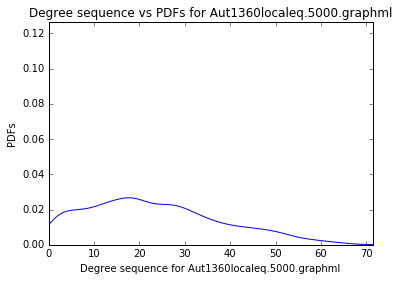

In [15]:
# Degree sequence
temp_deg = np.array(nx.degree(G).values())
deg = density(temp_deg)
# print deg
xs = deg['xs']
pdfs = deg['pdfs']

# Autoscale Output Image
pdfs = [i for i in pdfs if i >= 0.0001]
xs = xs[0: len(pdfs)]
xsMAX = np.amax(xs)
pdfsMAX = np.amax(pdfs)

# Plot File
plt.axis([0, xsMAX + 0.001, 0, pdfsMAX + 0.1])
plt.xlabel('Degree sequence for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Degree sequence vs PDFs for ' + filename)
fig1 = plt.plot(xs, pdfs)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'degreesequence.png', bbox_inches='tight')

# Make pickel
write('../pickels', 'degree sequence', deg, filename)

In [16]:
# Compute Edge Weight 
temp_ew = (G.get_edge_data(e[0], e[1])['weight'] for e in G.edges())
## ew = density(temp_ew) "ValueError: `dataset` input should have multiple elements."
print temp_ew
# We don't have edge weights so this makes sense

# Make pickel
# write('../pickels', 'edge weight', temp_ew, filename)

<generator object <genexpr> at 0x110eeb410>


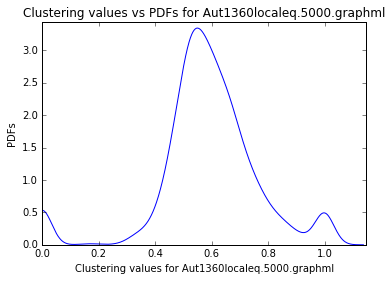

In [17]:
# Clustering Coefficients
nxc = nx.clustering 
temp_cc = nxc(G).values()
ccoefs = density(temp_cc)
xscc = ccoefs['xs']
pdfscc = ccoefs['pdfs']

# Autoscale Output Image
pdfscc = [i for i in pdfscc if i >= 0.0001]
xscc = xscc[0: len(pdfscc)]
xsccMAX = np.amax(xscc)
pdfsccMAX = np.amax(pdfscc)


# Plot File
plt.axis([0, xsccMAX + 0.01, 0, (pdfsccMAX + 0.1)])
plt.xlabel('Clustering values for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Clustering values vs PDFs for ' + filename)
fig2 = plt.plot(xscc, pdfscc)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename +'clusteringcoefficients.png', bbox_inches='tight')

# Make pickel
write('../pickels', 'clustering coefficient', ccoefs, filename)

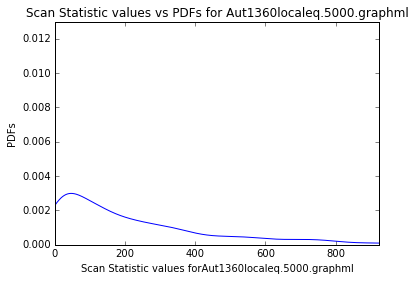

In [18]:
# Scan Statistic-1 
temp_ss1 = scan_statistic(G, 1)
ss1 = density(temp_ss1)

xsss = ss1['xs']
pdfsss = ss1['pdfs']

# Autoscale Output Image
pdfsss = [i for i in pdfsss if i >= 0.0001]
xsss = xsss[0: len(pdfsss)]
xsssMAX = np.amax(xsss)
pdfsssMAX = np.amax(pdfsss)

plt.axis([0, xsssMAX + 1, 0, pdfsssMAX + 0.01])
plt.xlabel('Scan Statistic values for' + filename)
plt.ylabel('PDFs')
plt.title(r'Scan Statistic values vs PDFs for ' + filename)
fig3 = plt.plot(xsss, pdfsss)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'scanstatistic.png')

# Make pickel
write('../pickels', 'scan statistic-1', ss1, filename)

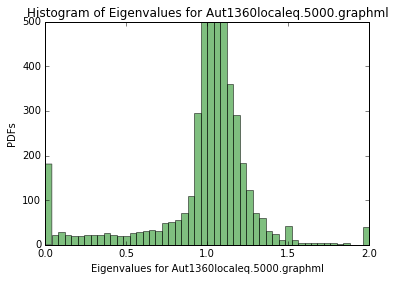

In [19]:
# EigenValues 
laplacian = nx.normalized_laplacian_matrix(G)
eigs = np.sort(np.linalg.eigvals(laplacian.A))[::-1]

num_bins = 50
# the histogram of the data
n, bins, patches = plt.hist(eigs, num_bins, facecolor='green', alpha=0.5)

plt.axis([0, 2, 0, 500])
plt.xlabel('Eigenvalues for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Histogram of Eigenvalues for ' + filename)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'eigenvalues.png')

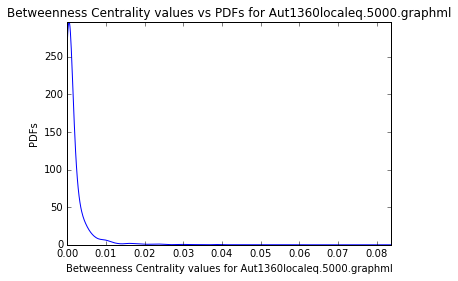

In [20]:
#Betweenness Centrality
nxbc = nx.algorithms.betweenness_centrality
temp_bc = (nxbc(G).values())
centrality = density(temp_bc)

xsbetween = centrality['xs']
pdfsbetween = centrality['pdfs']

# Autoscale Output Image
pdfsbetween = [i for i in pdfsbetween if i >= 0.0001]
xsbetween = xsbetween[0: len(pdfsbetween)]
xsbetweenMAX = np.amax(xsbetween)
pdfsbetweenMAX = np.amax(pdfsbetween)

# Plot
plt.axis([0, xsbetweenMAX, 0, pdfsbetweenMAX])
plt.xlabel('Betweenness Centrality values for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Betweenness Centrality values vs PDFs for ' + filename)
plt.plot(xsbetween, pdfsbetween)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'betweennesscentrality.png')

# Make pickel
write('../pickels', 'betweenness centrality', centrality, filename)

In [21]:
# Change the filename below to run different graphml files
filename = 'Aut1367localeq.5000.graphml'
G = nx.read_graphml(filename)

In [22]:
# NNZ - Number of non-zero edges
print len(nx.edges(G))
write('../pickels', 'non-zero_edges', nx.edges(G), filename)

1159


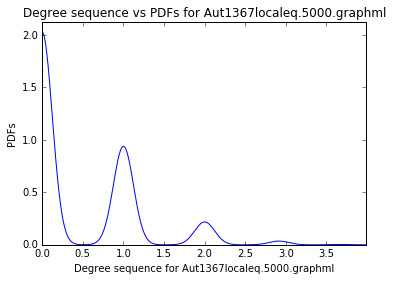

In [23]:
# Degree sequence
temp_deg = np.array(nx.degree(G).values())
deg = density(temp_deg)
# print deg
xs = deg['xs']
pdfs = deg['pdfs']

# Autoscale Output Image
pdfs = [i for i in pdfs if i >= 0.0001]
xs = xs[0: len(pdfs)]
xsMAX = np.amax(xs)
pdfsMAX = np.amax(pdfs)

# Plot File
plt.axis([0, xsMAX + 0.001, 0, pdfsMAX + 0.1])
plt.xlabel('Degree sequence for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Degree sequence vs PDFs for ' + filename)
fig1 = plt.plot(xs, pdfs)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'degreesequence.png', bbox_inches='tight')

# Make pickel
write('../pickels', 'degree sequence', deg, filename)

In [24]:
# Compute Edge Weight 
temp_ew = (G.get_edge_data(e[0], e[1])['weight'] for e in G.edges())
## ew = density(temp_ew) "ValueError: `dataset` input should have multiple elements."
print temp_ew
# We don't have edge weights so this makes sense

# Make pickel
# write('../pickels', 'edge weight', temp_ew, filename)

<generator object <genexpr> at 0x1122675a0>


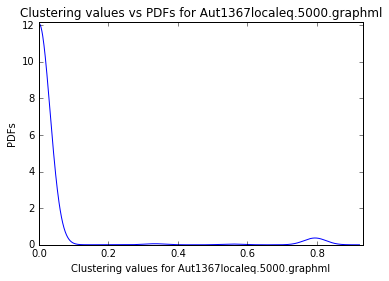

In [25]:
# Clustering Coefficients
nxc = nx.clustering 
temp_cc = nxc(G).values()
ccoefs = density(temp_cc)
xscc = ccoefs['xs']
pdfscc = ccoefs['pdfs']

# Autoscale Output Image
pdfscc = [i for i in pdfscc if i >= 0.0001]
xscc = xscc[0: len(pdfscc)]
xsccMAX = np.amax(xscc)
pdfsccMAX = np.amax(pdfscc)


# Plot File
plt.axis([0, xsccMAX + 0.01, 0, (pdfsccMAX + 0.1)])
plt.xlabel('Clustering values for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Clustering values vs PDFs for ' + filename)
fig2 = plt.plot(xscc, pdfscc)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename +'clusteringcoefficients.png', bbox_inches='tight')

# Make pickel
write('../pickels', 'clustering coefficient', ccoefs, filename)

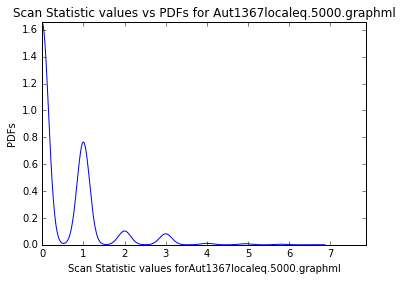

In [26]:
# Scan Statistic-1 
temp_ss1 = scan_statistic(G, 1)
ss1 = density(temp_ss1)

xsss = ss1['xs']
pdfsss = ss1['pdfs']

# Autoscale Output Image
pdfsss = [i for i in pdfsss if i >= 0.0001]
xsss = xsss[0: len(pdfsss)]
xsssMAX = np.amax(xsss)
pdfsssMAX = np.amax(pdfsss)

plt.axis([0, xsssMAX + 1, 0, pdfsssMAX + 0.01])
plt.xlabel('Scan Statistic values for' + filename)
plt.ylabel('PDFs')
plt.title(r'Scan Statistic values vs PDFs for ' + filename)
fig3 = plt.plot(xsss, pdfsss)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'scanstatistic.png')

# Make pickel
write('../pickels', 'scan statistic-1', ss1, filename)

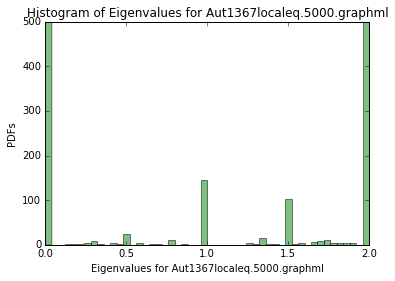

In [27]:
# EigenValues 
laplacian = nx.normalized_laplacian_matrix(G)
eigs = np.sort(np.linalg.eigvals(laplacian.A))[::-1]

num_bins = 50
# the histogram of the data
n, bins, patches = plt.hist(eigs, num_bins, facecolor='green', alpha=0.5)

plt.axis([0, 2, 0, 500])
plt.xlabel('Eigenvalues for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Histogram of Eigenvalues for ' + filename)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'eigenvalues.png')

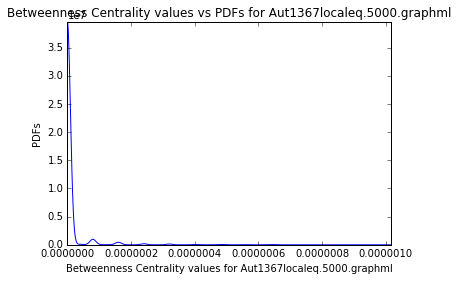

In [28]:
#Betweenness Centrality
nxbc = nx.algorithms.betweenness_centrality
temp_bc = (nxbc(G).values())
centrality = density(temp_bc)

xsbetween = centrality['xs']
pdfsbetween = centrality['pdfs']

# Autoscale Output Image
pdfsbetween = [i for i in pdfsbetween if i >= 0.0001]
xsbetween = xsbetween[0: len(pdfsbetween)]
xsbetweenMAX = np.amax(xsbetween)
pdfsbetweenMAX = np.amax(pdfsbetween)

# Plot
plt.axis([0, xsbetweenMAX, 0, pdfsbetweenMAX])
plt.xlabel('Betweenness Centrality values for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Betweenness Centrality values vs PDFs for ' + filename)
plt.plot(xsbetween, pdfsbetween)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'betweennesscentrality.png')

# Make pickel
write('../pickels', 'betweenness centrality', centrality, filename)

In [29]:
# Change the filename below to run different graphml files
filename = 'Aut1374localeq.5000.graphml'
G = nx.read_graphml(filename)

In [30]:
# NNZ - Number of non-zero edges
print len(nx.edges(G))
write('../pickels', 'non-zero_edges', nx.edges(G), filename)

26198


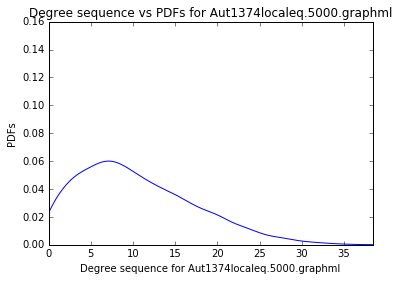

In [31]:
# Degree sequence
temp_deg = np.array(nx.degree(G).values())
deg = density(temp_deg)
# print deg
xs = deg['xs']
pdfs = deg['pdfs']

# Autoscale Output Image
pdfs = [i for i in pdfs if i >= 0.0001]
xs = xs[0: len(pdfs)]
xsMAX = np.amax(xs)
pdfsMAX = np.amax(pdfs)

# Plot File
plt.axis([0, xsMAX + 0.001, 0, pdfsMAX + 0.1])
plt.xlabel('Degree sequence for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Degree sequence vs PDFs for ' + filename)
fig1 = plt.plot(xs, pdfs)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'degreesequence.png', bbox_inches='tight')

# Make pickel
write('../pickels', 'degree sequence', deg, filename)

In [32]:
# Compute Edge Weight 
temp_ew = (G.get_edge_data(e[0], e[1])['weight'] for e in G.edges())
## ew = density(temp_ew) "ValueError: `dataset` input should have multiple elements."
print temp_ew
# We don't have edge weights so this makes sense

# Make pickel
# write('../pickels', 'edge weight', temp_ew, filename)

<generator object <genexpr> at 0x1121ed050>


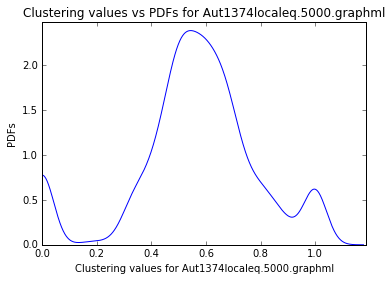

In [33]:
# Clustering Coefficients
nxc = nx.clustering 
temp_cc = nxc(G).values()
ccoefs = density(temp_cc)
xscc = ccoefs['xs']
pdfscc = ccoefs['pdfs']

# Autoscale Output Image
pdfscc = [i for i in pdfscc if i >= 0.0001]
xscc = xscc[0: len(pdfscc)]
xsccMAX = np.amax(xscc)
pdfsccMAX = np.amax(pdfscc)


# Plot File
plt.axis([0, xsccMAX + 0.01, 0, (pdfsccMAX + 0.1)])
plt.xlabel('Clustering values for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Clustering values vs PDFs for ' + filename)
fig2 = plt.plot(xscc, pdfscc)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename +'clusteringcoefficients.png', bbox_inches='tight')

# Make pickel
write('../pickels', 'clustering coefficient', ccoefs, filename)

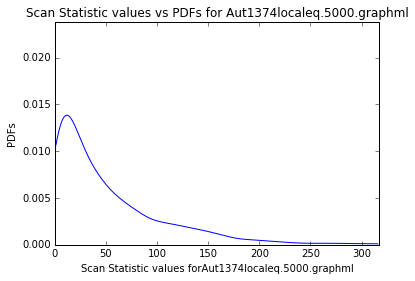

In [34]:
# Scan Statistic-1 
temp_ss1 = scan_statistic(G, 1)
ss1 = density(temp_ss1)

xsss = ss1['xs']
pdfsss = ss1['pdfs']

# Autoscale Output Image
pdfsss = [i for i in pdfsss if i >= 0.0001]
xsss = xsss[0: len(pdfsss)]
xsssMAX = np.amax(xsss)
pdfsssMAX = np.amax(pdfsss)

plt.axis([0, xsssMAX + 1, 0, pdfsssMAX + 0.01])
plt.xlabel('Scan Statistic values for' + filename)
plt.ylabel('PDFs')
plt.title(r'Scan Statistic values vs PDFs for ' + filename)
fig3 = plt.plot(xsss, pdfsss)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'scanstatistic.png')

# Make pickel
write('../pickels', 'scan statistic-1', ss1, filename)

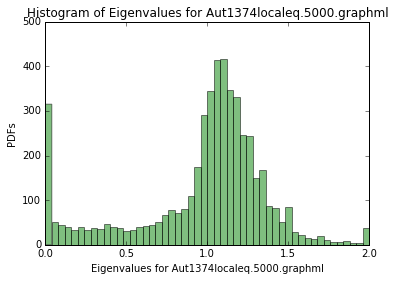

In [35]:
# EigenValues 
laplacian = nx.normalized_laplacian_matrix(G)
eigs = np.sort(np.linalg.eigvals(laplacian.A))[::-1]

num_bins = 50
# the histogram of the data
n, bins, patches = plt.hist(eigs, num_bins, facecolor='green', alpha=0.5)

plt.axis([0, 2, 0, 500])
plt.xlabel('Eigenvalues for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Histogram of Eigenvalues for ' + filename)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'eigenvalues.png')

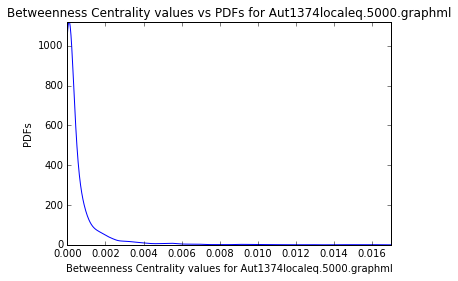

In [36]:
#Betweenness Centrality
nxbc = nx.algorithms.betweenness_centrality
temp_bc = (nxbc(G).values())
centrality = density(temp_bc)

xsbetween = centrality['xs']
pdfsbetween = centrality['pdfs']

# Autoscale Output Image
pdfsbetween = [i for i in pdfsbetween if i >= 0.0001]
xsbetween = xsbetween[0: len(pdfsbetween)]
xsbetweenMAX = np.amax(xsbetween)
pdfsbetweenMAX = np.amax(pdfsbetween)

# Plot
plt.axis([0, xsbetweenMAX, 0, pdfsbetweenMAX])
plt.xlabel('Betweenness Centrality values for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Betweenness Centrality values vs PDFs for ' + filename)
plt.plot(xsbetween, pdfsbetween)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'betweennesscentrality.png')

# Make pickel
write('../pickels', 'betweenness centrality', centrality, filename)

In [37]:
# Change the filename below to run different graphml files
filename = 'AutAlocaleq.5000.graphml'
G = nx.read_graphml(filename)

In [38]:
# NNZ - Number of non-zero edges
print len(nx.edges(G))
write('../pickels', 'non-zero_edges', nx.edges(G), filename)

7524


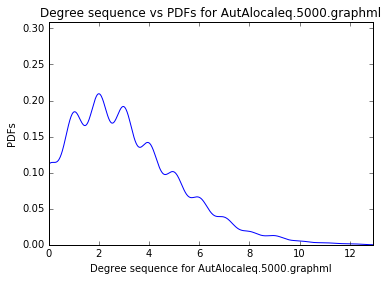

In [39]:
# Degree sequence
temp_deg = np.array(nx.degree(G).values())
deg = density(temp_deg)
# print deg
xs = deg['xs']
pdfs = deg['pdfs']

# Autoscale Output Image
pdfs = [i for i in pdfs if i >= 0.0001]
xs = xs[0: len(pdfs)]
xsMAX = np.amax(xs)
pdfsMAX = np.amax(pdfs)

# Plot File
plt.axis([0, xsMAX + 0.001, 0, pdfsMAX + 0.1])
plt.xlabel('Degree sequence for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Degree sequence vs PDFs for ' + filename)
fig1 = plt.plot(xs, pdfs)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'degreesequence.png', bbox_inches='tight')

# Make pickel
write('../pickels', 'degree sequence', deg, filename)

In [40]:
# Compute Edge Weight 
temp_ew = (G.get_edge_data(e[0], e[1])['weight'] for e in G.edges())
## ew = density(temp_ew) "ValueError: `dataset` input should have multiple elements."
print temp_ew
# We don't have edge weights so this makes sense

# Make pickel
# write('../pickels', 'edge weight', temp_ew, filename)

<generator object <genexpr> at 0x110eeeb90>


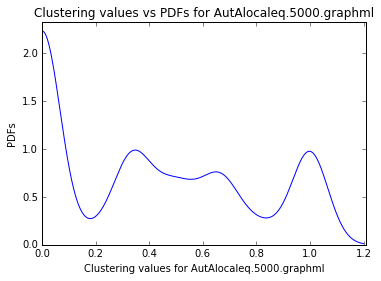

In [41]:
# Clustering Coefficients
nxc = nx.clustering 
temp_cc = nxc(G).values()
ccoefs = density(temp_cc)
xscc = ccoefs['xs']
pdfscc = ccoefs['pdfs']

# Autoscale Output Image
pdfscc = [i for i in pdfscc if i >= 0.0001]
xscc = xscc[0: len(pdfscc)]
xsccMAX = np.amax(xscc)
pdfsccMAX = np.amax(pdfscc)


# Plot File
plt.axis([0, xsccMAX + 0.01, 0, (pdfsccMAX + 0.1)])
plt.xlabel('Clustering values for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Clustering values vs PDFs for ' + filename)
fig2 = plt.plot(xscc, pdfscc)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename +'clusteringcoefficients.png', bbox_inches='tight')

# Make pickel
write('../pickels', 'clustering coefficient', ccoefs, filename)

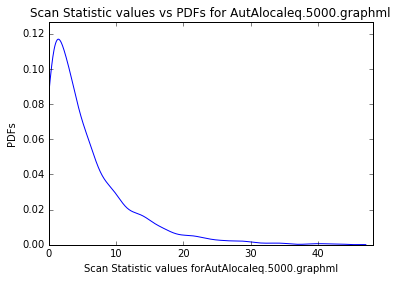

In [42]:
# Scan Statistic-1 
temp_ss1 = scan_statistic(G, 1)
ss1 = density(temp_ss1)

xsss = ss1['xs']
pdfsss = ss1['pdfs']

# Autoscale Output Image
pdfsss = [i for i in pdfsss if i >= 0.0001]
xsss = xsss[0: len(pdfsss)]
xsssMAX = np.amax(xsss)
pdfsssMAX = np.amax(pdfsss)

plt.axis([0, xsssMAX + 1, 0, pdfsssMAX + 0.01])
plt.xlabel('Scan Statistic values for' + filename)
plt.ylabel('PDFs')
plt.title(r'Scan Statistic values vs PDFs for ' + filename)
fig3 = plt.plot(xsss, pdfsss)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'scanstatistic.png')

# Make pickel
write('../pickels', 'scan statistic-1', ss1, filename)

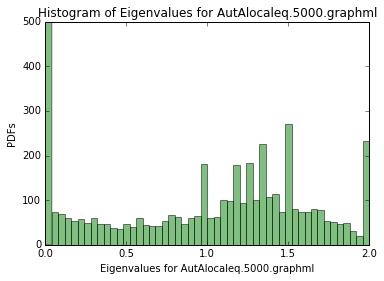

In [43]:
# EigenValues 
laplacian = nx.normalized_laplacian_matrix(G)
eigs = np.sort(np.linalg.eigvals(laplacian.A))[::-1]

num_bins = 50
# the histogram of the data
n, bins, patches = plt.hist(eigs, num_bins, facecolor='green', alpha=0.5)

plt.axis([0, 2, 0, 500])
plt.xlabel('Eigenvalues for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Histogram of Eigenvalues for ' + filename)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'eigenvalues.png')

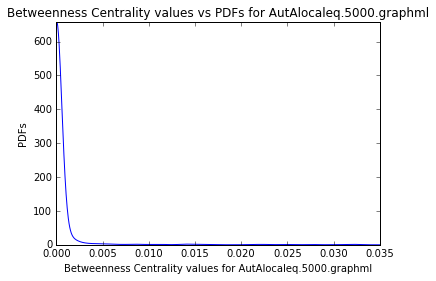

In [44]:
#Betweenness Centrality
nxbc = nx.algorithms.betweenness_centrality
temp_bc = (nxbc(G).values())
centrality = density(temp_bc)

xsbetween = centrality['xs']
pdfsbetween = centrality['pdfs']

# Autoscale Output Image
pdfsbetween = [i for i in pdfsbetween if i >= 0.0001]
xsbetween = xsbetween[0: len(pdfsbetween)]
xsbetweenMAX = np.amax(xsbetween)
pdfsbetweenMAX = np.amax(pdfsbetween)

# Plot
plt.axis([0, xsbetweenMAX, 0, pdfsbetweenMAX])
plt.xlabel('Betweenness Centrality values for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Betweenness Centrality values vs PDFs for ' + filename)
plt.plot(xsbetween, pdfsbetween)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'betweennesscentrality.png')

# Make pickel
write('../pickels', 'betweenness centrality', centrality, filename)

In [45]:
# Change the filename below to run different graphml files
filename = 'Cocaine174localeq.5000.graphml'
G = nx.read_graphml(filename)

In [46]:
# NNZ - Number of non-zero edges
print len(nx.edges(G))
write('../pickels', 'non-zero_edges', nx.edges(G), filename)

14701


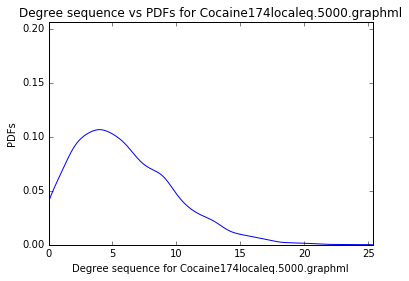

In [47]:
# Degree sequence
temp_deg = np.array(nx.degree(G).values())
deg = density(temp_deg)
# print deg
xs = deg['xs']
pdfs = deg['pdfs']

# Autoscale Output Image
pdfs = [i for i in pdfs if i >= 0.0001]
xs = xs[0: len(pdfs)]
xsMAX = np.amax(xs)
pdfsMAX = np.amax(pdfs)

# Plot File
plt.axis([0, xsMAX + 0.001, 0, pdfsMAX + 0.1])
plt.xlabel('Degree sequence for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Degree sequence vs PDFs for ' + filename)
fig1 = plt.plot(xs, pdfs)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'degreesequence.png', bbox_inches='tight')

# Make pickel
write('../pickels', 'degree sequence', deg, filename)

In [48]:
# Compute Edge Weight 
temp_ew = (G.get_edge_data(e[0], e[1])['weight'] for e in G.edges())
## ew = density(temp_ew) "ValueError: `dataset` input should have multiple elements."
print temp_ew
# We don't have edge weights so this makes sense

# Make pickel
# write('../pickels', 'edge weight', temp_ew, filename)

<generator object <genexpr> at 0x10fa23190>


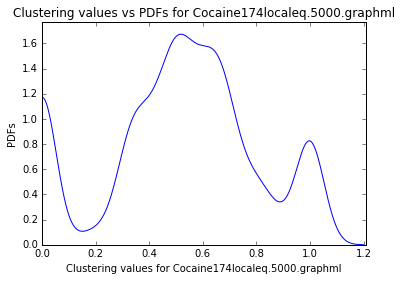

In [49]:
# Clustering Coefficients
nxc = nx.clustering 
temp_cc = nxc(G).values()
ccoefs = density(temp_cc)
xscc = ccoefs['xs']
pdfscc = ccoefs['pdfs']

# Autoscale Output Image
pdfscc = [i for i in pdfscc if i >= 0.0001]
xscc = xscc[0: len(pdfscc)]
xsccMAX = np.amax(xscc)
pdfsccMAX = np.amax(pdfscc)


# Plot File
plt.axis([0, xsccMAX + 0.01, 0, (pdfsccMAX + 0.1)])
plt.xlabel('Clustering values for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Clustering values vs PDFs for ' + filename)
fig2 = plt.plot(xscc, pdfscc)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename +'clusteringcoefficients.png', bbox_inches='tight')

# Make pickel
write('../pickels', 'clustering coefficient', ccoefs, filename)

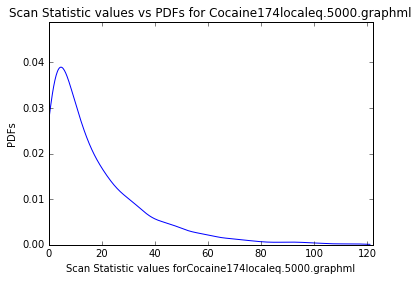

In [50]:
# Scan Statistic-1 
temp_ss1 = scan_statistic(G, 1)
ss1 = density(temp_ss1)

xsss = ss1['xs']
pdfsss = ss1['pdfs']

# Autoscale Output Image
pdfsss = [i for i in pdfsss if i >= 0.0001]
xsss = xsss[0: len(pdfsss)]
xsssMAX = np.amax(xsss)
pdfsssMAX = np.amax(pdfsss)

plt.axis([0, xsssMAX + 1, 0, pdfsssMAX + 0.01])
plt.xlabel('Scan Statistic values for' + filename)
plt.ylabel('PDFs')
plt.title(r'Scan Statistic values vs PDFs for ' + filename)
fig3 = plt.plot(xsss, pdfsss)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'scanstatistic.png')

# Make pickel
write('../pickels', 'scan statistic-1', ss1, filename)

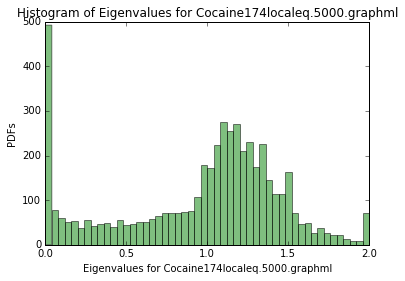

In [51]:
# EigenValues 
laplacian = nx.normalized_laplacian_matrix(G)
eigs = np.sort(np.linalg.eigvals(laplacian.A))[::-1]

num_bins = 50
# the histogram of the data
n, bins, patches = plt.hist(eigs, num_bins, facecolor='green', alpha=0.5)

plt.axis([0, 2, 0, 500])
plt.xlabel('Eigenvalues for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Histogram of Eigenvalues for ' + filename)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'eigenvalues.png')

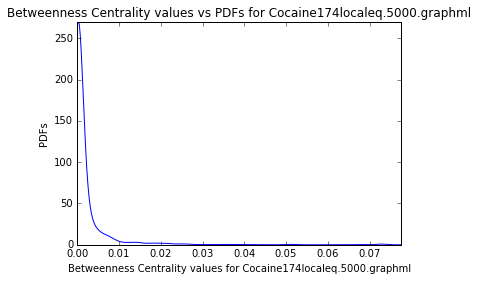

In [52]:
#Betweenness Centrality
nxbc = nx.algorithms.betweenness_centrality
temp_bc = (nxbc(G).values())
centrality = density(temp_bc)

xsbetween = centrality['xs']
pdfsbetween = centrality['pdfs']

# Autoscale Output Image
pdfsbetween = [i for i in pdfsbetween if i >= 0.0001]
xsbetween = xsbetween[0: len(pdfsbetween)]
xsbetweenMAX = np.amax(xsbetween)
pdfsbetweenMAX = np.amax(pdfsbetween)

# Plot
plt.axis([0, xsbetweenMAX, 0, pdfsbetweenMAX])
plt.xlabel('Betweenness Centrality values for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Betweenness Centrality values vs PDFs for ' + filename)
plt.plot(xsbetween, pdfsbetween)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'betweennesscentrality.png')

# Make pickel
write('../pickels', 'betweenness centrality', centrality, filename)

In [53]:
# Change the filename below to run different graphml files
filename = 'Cocaine175localeq.5000.graphml'
G = nx.read_graphml(filename)

In [54]:
# NNZ - Number of non-zero edges
print len(nx.edges(G))
write('../pickels', 'non-zero_edges', nx.edges(G), filename)

29456


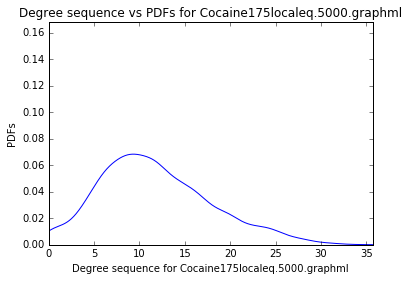

In [55]:
# Degree sequence
temp_deg = np.array(nx.degree(G).values())
deg = density(temp_deg)
# print deg
xs = deg['xs']
pdfs = deg['pdfs']

# Autoscale Output Image
pdfs = [i for i in pdfs if i >= 0.0001]
xs = xs[0: len(pdfs)]
xsMAX = np.amax(xs)
pdfsMAX = np.amax(pdfs)

# Plot File
plt.axis([0, xsMAX + 0.001, 0, pdfsMAX + 0.1])
plt.xlabel('Degree sequence for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Degree sequence vs PDFs for ' + filename)
fig1 = plt.plot(xs, pdfs)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'degreesequence.png', bbox_inches='tight')

# Make pickel
write('../pickels', 'degree sequence', deg, filename)

In [56]:
# Compute Edge Weight 
temp_ew = (G.get_edge_data(e[0], e[1])['weight'] for e in G.edges())
## ew = density(temp_ew) "ValueError: `dataset` input should have multiple elements."
print temp_ew
# We don't have edge weights so this makes sense

# Make pickel
# write('../pickels', 'edge weight', temp_ew, filename)

<generator object <genexpr> at 0x1121edaa0>


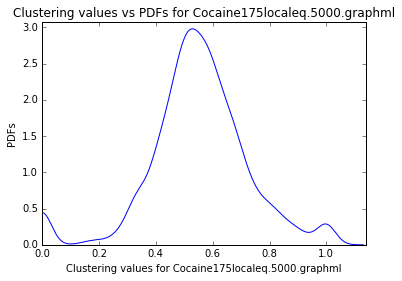

In [57]:
# Clustering Coefficients
nxc = nx.clustering 
temp_cc = nxc(G).values()
ccoefs = density(temp_cc)
xscc = ccoefs['xs']
pdfscc = ccoefs['pdfs']

# Autoscale Output Image
pdfscc = [i for i in pdfscc if i >= 0.0001]
xscc = xscc[0: len(pdfscc)]
xsccMAX = np.amax(xscc)
pdfsccMAX = np.amax(pdfscc)


# Plot File
plt.axis([0, xsccMAX + 0.01, 0, (pdfsccMAX + 0.1)])
plt.xlabel('Clustering values for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Clustering values vs PDFs for ' + filename)
fig2 = plt.plot(xscc, pdfscc)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename +'clusteringcoefficients.png', bbox_inches='tight')

# Make pickel
write('../pickels', 'clustering coefficient', ccoefs, filename)

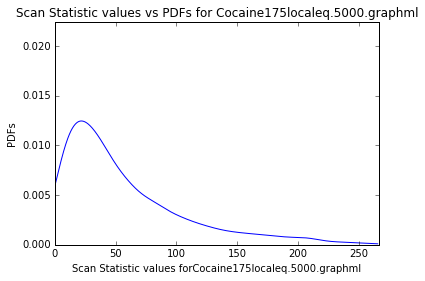

In [58]:
# Scan Statistic-1 
temp_ss1 = scan_statistic(G, 1)
ss1 = density(temp_ss1)

xsss = ss1['xs']
pdfsss = ss1['pdfs']

# Autoscale Output Image
pdfsss = [i for i in pdfsss if i >= 0.0001]
xsss = xsss[0: len(pdfsss)]
xsssMAX = np.amax(xsss)
pdfsssMAX = np.amax(pdfsss)

plt.axis([0, xsssMAX + 1, 0, pdfsssMAX + 0.01])
plt.xlabel('Scan Statistic values for' + filename)
plt.ylabel('PDFs')
plt.title(r'Scan Statistic values vs PDFs for ' + filename)
fig3 = plt.plot(xsss, pdfsss)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'scanstatistic.png')

# Make pickel
write('../pickels', 'scan statistic-1', ss1, filename)

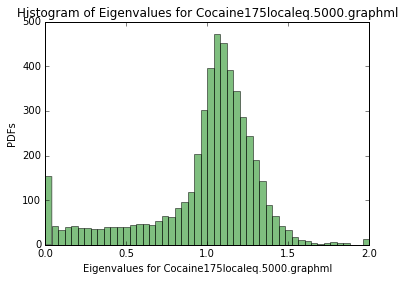

In [59]:
# EigenValues 
laplacian = nx.normalized_laplacian_matrix(G)
eigs = np.sort(np.linalg.eigvals(laplacian.A))[::-1]

num_bins = 50
# the histogram of the data
n, bins, patches = plt.hist(eigs, num_bins, facecolor='green', alpha=0.5)

plt.axis([0, 2, 0, 500])
plt.xlabel('Eigenvalues for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Histogram of Eigenvalues for ' + filename)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'eigenvalues.png')

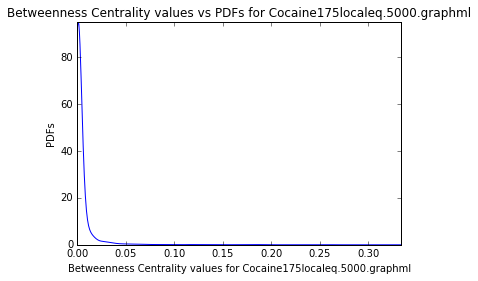

In [60]:
#Betweenness Centrality
nxbc = nx.algorithms.betweenness_centrality
temp_bc = (nxbc(G).values())
centrality = density(temp_bc)

xsbetween = centrality['xs']
pdfsbetween = centrality['pdfs']

# Autoscale Output Image
pdfsbetween = [i for i in pdfsbetween if i >= 0.0001]
xsbetween = xsbetween[0: len(pdfsbetween)]
xsbetweenMAX = np.amax(xsbetween)
pdfsbetweenMAX = np.amax(pdfsbetween)

# Plot
plt.axis([0, xsbetweenMAX, 0, pdfsbetweenMAX])
plt.xlabel('Betweenness Centrality values for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Betweenness Centrality values vs PDFs for ' + filename)
plt.plot(xsbetween, pdfsbetween)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'betweennesscentrality.png')

# Make pickel
write('../pickels', 'betweenness centrality', centrality, filename)

In [61]:
# Change the filename below to run different graphml files
filename = 'Cocaine178localeq.5000.graphml'
G = nx.read_graphml(filename)

In [62]:
# NNZ - Number of non-zero edges
print len(nx.edges(G))
write('../pickels', 'non-zero_edges', nx.edges(G), filename)

14018


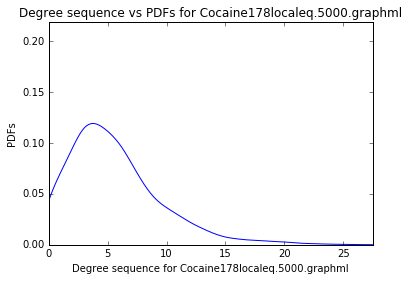

In [63]:
# Degree sequence
temp_deg = np.array(nx.degree(G).values())
deg = density(temp_deg)
# print deg
xs = deg['xs']
pdfs = deg['pdfs']

# Autoscale Output Image
pdfs = [i for i in pdfs if i >= 0.0001]
xs = xs[0: len(pdfs)]
xsMAX = np.amax(xs)
pdfsMAX = np.amax(pdfs)

# Plot File
plt.axis([0, xsMAX + 0.001, 0, pdfsMAX + 0.1])
plt.xlabel('Degree sequence for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Degree sequence vs PDFs for ' + filename)
fig1 = plt.plot(xs, pdfs)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'degreesequence.png', bbox_inches='tight')

# Make pickel
write('../pickels', 'degree sequence', deg, filename)

In [64]:
# Compute Edge Weight 
temp_ew = (G.get_edge_data(e[0], e[1])['weight'] for e in G.edges())
## ew = density(temp_ew) "ValueError: `dataset` input should have multiple elements."
print temp_ew
# We don't have edge weights so this makes sense

# Make pickel
# write('../pickels', 'edge weight', temp_ew, filename)

<generator object <genexpr> at 0x1199bee60>


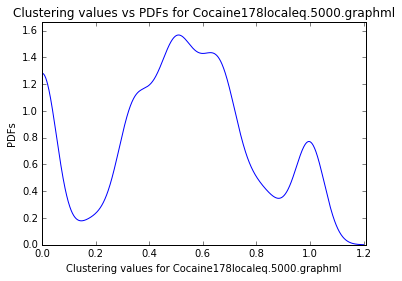

In [65]:
# Clustering Coefficients
nxc = nx.clustering 
temp_cc = nxc(G).values()
ccoefs = density(temp_cc)
xscc = ccoefs['xs']
pdfscc = ccoefs['pdfs']

# Autoscale Output Image
pdfscc = [i for i in pdfscc if i >= 0.0001]
xscc = xscc[0: len(pdfscc)]
xsccMAX = np.amax(xscc)
pdfsccMAX = np.amax(pdfscc)


# Plot File
plt.axis([0, xsccMAX + 0.01, 0, (pdfsccMAX + 0.1)])
plt.xlabel('Clustering values for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Clustering values vs PDFs for ' + filename)
fig2 = plt.plot(xscc, pdfscc)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename +'clusteringcoefficients.png', bbox_inches='tight')

# Make pickel
write('../pickels', 'clustering coefficient', ccoefs, filename)

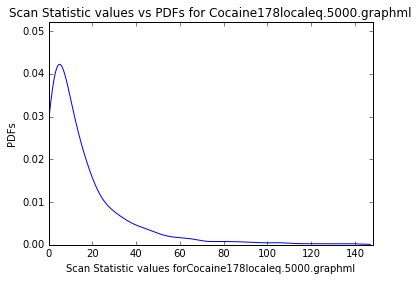

In [66]:
# Scan Statistic-1 
temp_ss1 = scan_statistic(G, 1)
ss1 = density(temp_ss1)

xsss = ss1['xs']
pdfsss = ss1['pdfs']

# Autoscale Output Image
pdfsss = [i for i in pdfsss if i >= 0.0001]
xsss = xsss[0: len(pdfsss)]
xsssMAX = np.amax(xsss)
pdfsssMAX = np.amax(pdfsss)

plt.axis([0, xsssMAX + 1, 0, pdfsssMAX + 0.01])
plt.xlabel('Scan Statistic values for' + filename)
plt.ylabel('PDFs')
plt.title(r'Scan Statistic values vs PDFs for ' + filename)
fig3 = plt.plot(xsss, pdfsss)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'scanstatistic.png')

# Make pickel
write('../pickels', 'scan statistic-1', ss1, filename)

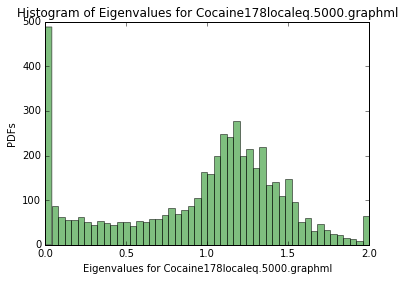

In [67]:
# EigenValues 
laplacian = nx.normalized_laplacian_matrix(G)
eigs = np.sort(np.linalg.eigvals(laplacian.A))[::-1]

num_bins = 50
# the histogram of the data
n, bins, patches = plt.hist(eigs, num_bins, facecolor='green', alpha=0.5)

plt.axis([0, 2, 0, 500])
plt.xlabel('Eigenvalues for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Histogram of Eigenvalues for ' + filename)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'eigenvalues.png')


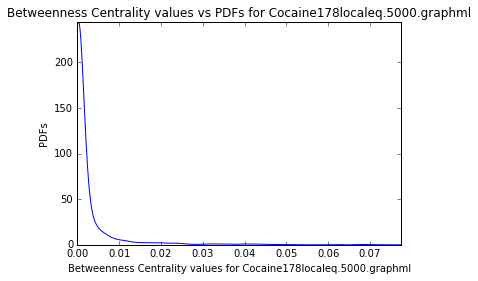

In [68]:
#Betweenness Centrality
nxbc = nx.algorithms.betweenness_centrality
temp_bc = (nxbc(G).values())
centrality = density(temp_bc)

xsbetween = centrality['xs']
pdfsbetween = centrality['pdfs']

# Autoscale Output Image
pdfsbetween = [i for i in pdfsbetween if i >= 0.0001]
xsbetween = xsbetween[0: len(pdfsbetween)]
xsbetweenMAX = np.amax(xsbetween)
pdfsbetweenMAX = np.amax(pdfsbetween)

# Plot
plt.axis([0, xsbetweenMAX, 0, pdfsbetweenMAX])
plt.xlabel('Betweenness Centrality values for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Betweenness Centrality values vs PDFs for ' + filename)
plt.plot(xsbetween, pdfsbetween)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'betweennesscentrality.png')

# Make pickel
write('../pickels', 'betweenness centrality', centrality, filename)

In [69]:
# Change the filename below to run different graphml files
filename = 'Control181localeq.5000.graphml'
G = nx.read_graphml(filename)

In [70]:
# NNZ - Number of non-zero edges
print len(nx.edges(G))
write('../pickels', 'non-zero_edges', nx.edges(G), filename)

13145


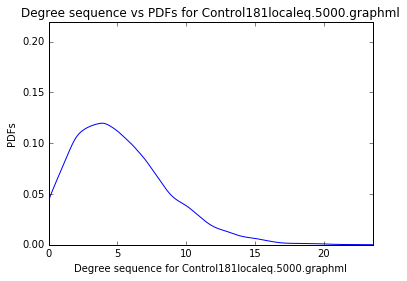

In [71]:
# Degree sequence
temp_deg = np.array(nx.degree(G).values())
deg = density(temp_deg)
# print deg
xs = deg['xs']
pdfs = deg['pdfs']

# Autoscale Output Image
pdfs = [i for i in pdfs if i >= 0.0001]
xs = xs[0: len(pdfs)]
xsMAX = np.amax(xs)
pdfsMAX = np.amax(pdfs)

# Plot File
plt.axis([0, xsMAX + 0.001, 0, pdfsMAX + 0.1])
plt.xlabel('Degree sequence for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Degree sequence vs PDFs for ' + filename)
fig1 = plt.plot(xs, pdfs)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'degreesequence.png', bbox_inches='tight')

# Make pickel
write('../pickels', 'degree sequence', deg, filename)

In [72]:
# Compute Edge Weight 
temp_ew = (G.get_edge_data(e[0], e[1])['weight'] for e in G.edges())
## ew = density(temp_ew) "ValueError: `dataset` input should have multiple elements."
print temp_ew
# We don't have edge weights so this makes sense

# Make pickel
# write('../pickels', 'edge weight', temp_ew, filename)

<generator object <genexpr> at 0x11165e640>


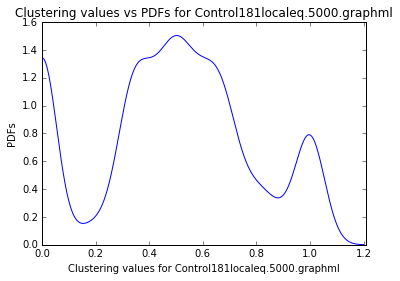

In [73]:
# Clustering Coefficients
nxc = nx.clustering 
temp_cc = nxc(G).values()
ccoefs = density(temp_cc)
xscc = ccoefs['xs']
pdfscc = ccoefs['pdfs']

# Autoscale Output Image
pdfscc = [i for i in pdfscc if i >= 0.0001]
xscc = xscc[0: len(pdfscc)]
xsccMAX = np.amax(xscc)
pdfsccMAX = np.amax(pdfscc)


# Plot File
plt.axis([0, xsccMAX + 0.01, 0, (pdfsccMAX + 0.1)])
plt.xlabel('Clustering values for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Clustering values vs PDFs for ' + filename)
fig2 = plt.plot(xscc, pdfscc)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename +'clusteringcoefficients.png', bbox_inches='tight')

# Make pickel
write('../pickels', 'clustering coefficient', ccoefs, filename)

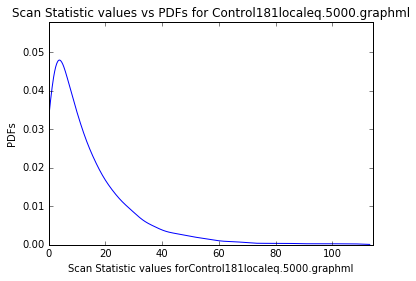

In [74]:
# Scan Statistic-1 
temp_ss1 = scan_statistic(G, 1)
ss1 = density(temp_ss1)

xsss = ss1['xs']
pdfsss = ss1['pdfs']

# Autoscale Output Image
pdfsss = [i for i in pdfsss if i >= 0.0001]
xsss = xsss[0: len(pdfsss)]
xsssMAX = np.amax(xsss)
pdfsssMAX = np.amax(pdfsss)

plt.axis([0, xsssMAX + 1, 0, pdfsssMAX + 0.01])
plt.xlabel('Scan Statistic values for' + filename)
plt.ylabel('PDFs')
plt.title(r'Scan Statistic values vs PDFs for ' + filename)
fig3 = plt.plot(xsss, pdfsss)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'scanstatistic.png')

# Make pickel
write('../pickels', 'scan statistic-1', ss1, filename)

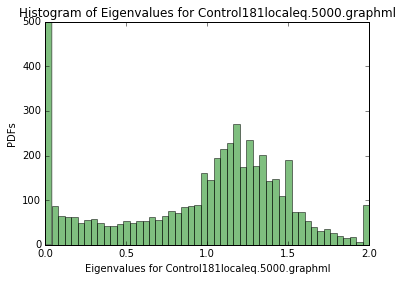

In [75]:
# EigenValues 
laplacian = nx.normalized_laplacian_matrix(G)
eigs = np.sort(np.linalg.eigvals(laplacian.A))[::-1]

num_bins = 50
# the histogram of the data
n, bins, patches = plt.hist(eigs, num_bins, facecolor='green', alpha=0.5)

plt.axis([0, 2, 0, 500])
plt.xlabel('Eigenvalues for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Histogram of Eigenvalues for ' + filename)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'eigenvalues.png')

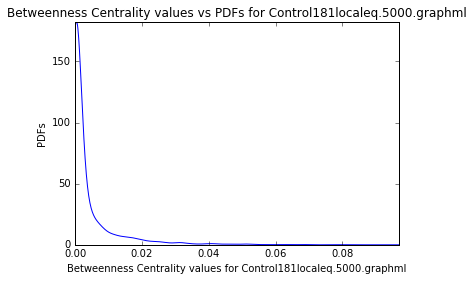

In [76]:
#Betweenness Centrality
nxbc = nx.algorithms.betweenness_centrality
temp_bc = (nxbc(G).values())
centrality = density(temp_bc)

xsbetween = centrality['xs']
pdfsbetween = centrality['pdfs']

# Autoscale Output Image
pdfsbetween = [i for i in pdfsbetween if i >= 0.0001]
xsbetween = xsbetween[0: len(pdfsbetween)]
xsbetweenMAX = np.amax(xsbetween)
pdfsbetweenMAX = np.amax(pdfsbetween)

# Plot
plt.axis([0, xsbetweenMAX, 0, pdfsbetweenMAX])
plt.xlabel('Betweenness Centrality values for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Betweenness Centrality values vs PDFs for ' + filename)
plt.plot(xsbetween, pdfsbetween)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'betweennesscentrality.png')

# Make pickel
write('../pickels', 'betweenness centrality', centrality, filename)

In [77]:
# Change the filename below to run different graphml files
filename = 'Control182localeq.5000.graphml'
G = nx.read_graphml(filename)

In [78]:
# NNZ - Number of non-zero edges
print len(nx.edges(G))
write('../pickels', 'non-zero_edges', nx.edges(G), filename)

25756


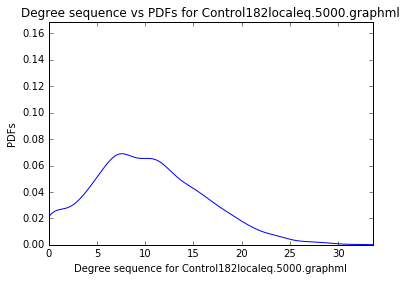

In [79]:
# Degree sequence
temp_deg = np.array(nx.degree(G).values())
deg = density(temp_deg)
# print deg
xs = deg['xs']
pdfs = deg['pdfs']

# Autoscale Output Image
pdfs = [i for i in pdfs if i >= 0.0001]
xs = xs[0: len(pdfs)]
xsMAX = np.amax(xs)
pdfsMAX = np.amax(pdfs)

# Plot File
plt.axis([0, xsMAX + 0.001, 0, pdfsMAX + 0.1])
plt.xlabel('Degree sequence for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Degree sequence vs PDFs for ' + filename)
fig1 = plt.plot(xs, pdfs)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'degreesequence.png', bbox_inches='tight')

# Make pickel
write('../pickels', 'degree sequence', deg, filename)

In [80]:
# Compute Edge Weight 
temp_ew = (G.get_edge_data(e[0], e[1])['weight'] for e in G.edges())
## ew = density(temp_ew) "ValueError: `dataset` input should have multiple elements."
print temp_ew
# We don't have edge weights so this makes sense

# Make pickel
# write('../pickels', 'edge weight', temp_ew, filename)

<generator object <genexpr> at 0x111f02aa0>


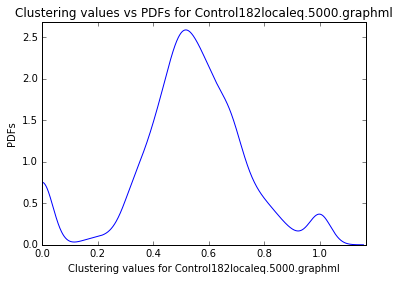

In [81]:
# Clustering Coefficients
nxc = nx.clustering 
temp_cc = nxc(G).values()
ccoefs = density(temp_cc)
xscc = ccoefs['xs']
pdfscc = ccoefs['pdfs']

# Autoscale Output Image
pdfscc = [i for i in pdfscc if i >= 0.0001]
xscc = xscc[0: len(pdfscc)]
xsccMAX = np.amax(xscc)
pdfsccMAX = np.amax(pdfscc)


# Plot File
plt.axis([0, xsccMAX + 0.01, 0, (pdfsccMAX + 0.1)])
plt.xlabel('Clustering values for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Clustering values vs PDFs for ' + filename)
fig2 = plt.plot(xscc, pdfscc)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename +'clusteringcoefficients.png', bbox_inches='tight')

# Make pickel
write('../pickels', 'clustering coefficient', ccoefs, filename)

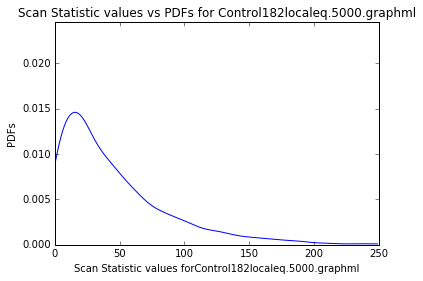

In [82]:
# Scan Statistic-1 
temp_ss1 = scan_statistic(G, 1)
ss1 = density(temp_ss1)

xsss = ss1['xs']
pdfsss = ss1['pdfs']

# Autoscale Output Image
pdfsss = [i for i in pdfsss if i >= 0.0001]
xsss = xsss[0: len(pdfsss)]
xsssMAX = np.amax(xsss)
pdfsssMAX = np.amax(pdfsss)

plt.axis([0, xsssMAX + 1, 0, pdfsssMAX + 0.01])
plt.xlabel('Scan Statistic values for' + filename)
plt.ylabel('PDFs')
plt.title(r'Scan Statistic values vs PDFs for ' + filename)
fig3 = plt.plot(xsss, pdfsss)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'scanstatistic.png')

# Make pickel
write('../pickels', 'scan statistic-1', ss1, filename)

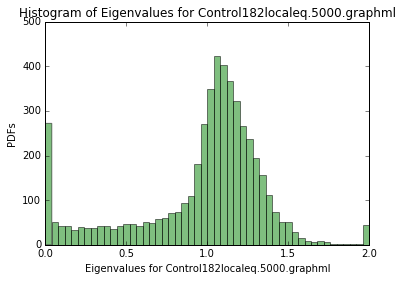

In [83]:
# EigenValues 
laplacian = nx.normalized_laplacian_matrix(G)
eigs = np.sort(np.linalg.eigvals(laplacian.A))[::-1]

num_bins = 50
# the histogram of the data
n, bins, patches = plt.hist(eigs, num_bins, facecolor='green', alpha=0.5)

plt.axis([0, 2, 0, 500])
plt.xlabel('Eigenvalues for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Histogram of Eigenvalues for ' + filename)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'eigenvalues.png')

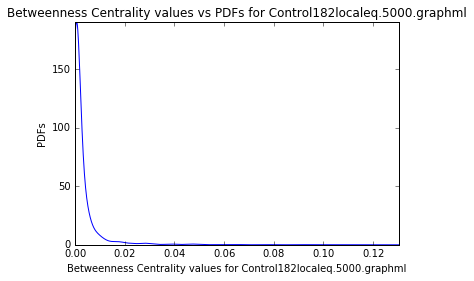

In [84]:
#Betweenness Centrality
nxbc = nx.algorithms.betweenness_centrality
temp_bc = (nxbc(G).values())
centrality = density(temp_bc)

xsbetween = centrality['xs']
pdfsbetween = centrality['pdfs']

# Autoscale Output Image
pdfsbetween = [i for i in pdfsbetween if i >= 0.0001]
xsbetween = xsbetween[0: len(pdfsbetween)]
xsbetweenMAX = np.amax(xsbetween)
pdfsbetweenMAX = np.amax(pdfsbetween)

# Plot
plt.axis([0, xsbetweenMAX, 0, pdfsbetweenMAX])
plt.xlabel('Betweenness Centrality values for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Betweenness Centrality values vs PDFs for ' + filename)
plt.plot(xsbetween, pdfsbetween)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'betweennesscentrality.png')

# Make pickel
write('../pickels', 'betweenness centrality', centrality, filename)

In [85]:
# Change the filename below to run different graphml files
filename = 'Control189localeq.5000.graphml'
G = nx.read_graphml(filename)

In [86]:
# NNZ - Number of non-zero edges
print len(nx.edges(G))
write('../pickels', 'non-zero_edges', nx.edges(G), filename)

42232


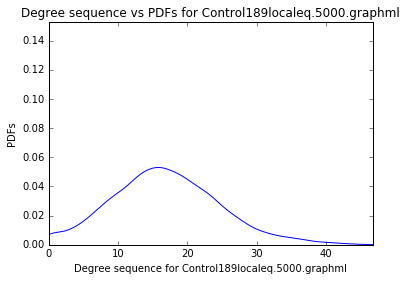

In [87]:
# Degree sequence
temp_deg = np.array(nx.degree(G).values())
deg = density(temp_deg)
# print deg
xs = deg['xs']
pdfs = deg['pdfs']

# Autoscale Output Image
pdfs = [i for i in pdfs if i >= 0.0001]
xs = xs[0: len(pdfs)]
xsMAX = np.amax(xs)
pdfsMAX = np.amax(pdfs)

# Plot File
plt.axis([0, xsMAX + 0.001, 0, pdfsMAX + 0.1])
plt.xlabel('Degree sequence for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Degree sequence vs PDFs for ' + filename)
fig1 = plt.plot(xs, pdfs)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'degreesequence.png', bbox_inches='tight')

# Make pickel
write('../pickels', 'degree sequence', deg, filename)

In [88]:
# Compute Edge Weight 
temp_ew = (G.get_edge_data(e[0], e[1])['weight'] for e in G.edges())
## ew = density(temp_ew) "ValueError: `dataset` input should have multiple elements."
print temp_ew
# We don't have edge weights so this makes sense

# Make pickel
# write('../pickels', 'edge weight', temp_ew, filename)

<generator object <genexpr> at 0x118b770f0>


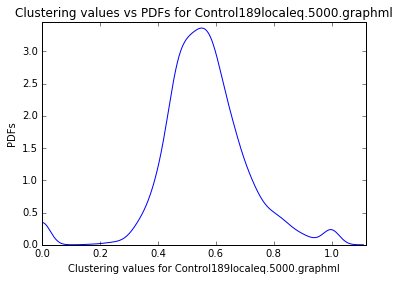

In [89]:
# Clustering Coefficients
nxc = nx.clustering 
temp_cc = nxc(G).values()
ccoefs = density(temp_cc)
xscc = ccoefs['xs']
pdfscc = ccoefs['pdfs']

# Autoscale Output Image
pdfscc = [i for i in pdfscc if i >= 0.0001]
xscc = xscc[0: len(pdfscc)]
xsccMAX = np.amax(xscc)
pdfsccMAX = np.amax(pdfscc)


# Plot File
plt.axis([0, xsccMAX + 0.01, 0, (pdfsccMAX + 0.1)])
plt.xlabel('Clustering values for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Clustering values vs PDFs for ' + filename)
fig2 = plt.plot(xscc, pdfscc)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename +'clusteringcoefficients.png', bbox_inches='tight')

# Make pickel
write('../pickels', 'clustering coefficient', ccoefs, filename)

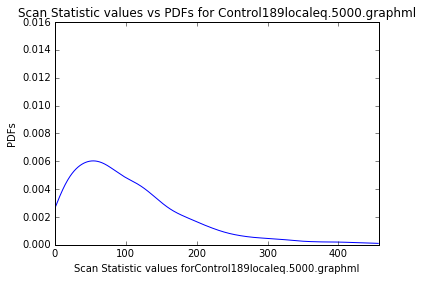

In [90]:
# Scan Statistic-1 
temp_ss1 = scan_statistic(G, 1)
ss1 = density(temp_ss1)

xsss = ss1['xs']
pdfsss = ss1['pdfs']

# Autoscale Output Image
pdfsss = [i for i in pdfsss if i >= 0.0001]
xsss = xsss[0: len(pdfsss)]
xsssMAX = np.amax(xsss)
pdfsssMAX = np.amax(pdfsss)

plt.axis([0, xsssMAX + 1, 0, pdfsssMAX + 0.01])
plt.xlabel('Scan Statistic values for' + filename)
plt.ylabel('PDFs')
plt.title(r'Scan Statistic values vs PDFs for ' + filename)
fig3 = plt.plot(xsss, pdfsss)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'scanstatistic.png')

# Make pickel
write('../pickels', 'scan statistic-1', ss1, filename)

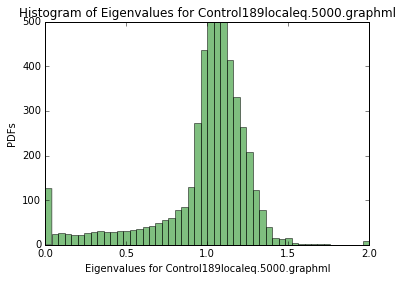

In [91]:
# EigenValues 
laplacian = nx.normalized_laplacian_matrix(G)
eigs = np.sort(np.linalg.eigvals(laplacian.A))[::-1]

num_bins = 50
# the histogram of the data
n, bins, patches = plt.hist(eigs, num_bins, facecolor='green', alpha=0.5)

plt.axis([0, 2, 0, 500])
plt.xlabel('Eigenvalues for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Histogram of Eigenvalues for ' + filename)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'eigenvalues.png')

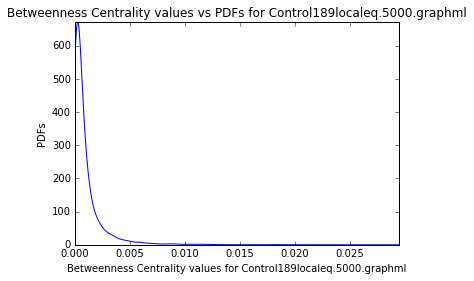

In [92]:
#Betweenness Centrality
nxbc = nx.algorithms.betweenness_centrality
temp_bc = (nxbc(G).values())
centrality = density(temp_bc)

xsbetween = centrality['xs']
pdfsbetween = centrality['pdfs']

# Autoscale Output Image
pdfsbetween = [i for i in pdfsbetween if i >= 0.0001]
xsbetween = xsbetween[0: len(pdfsbetween)]
xsbetweenMAX = np.amax(xsbetween)
pdfsbetweenMAX = np.amax(pdfsbetween)

# Plot
plt.axis([0, xsbetweenMAX, 0, pdfsbetweenMAX])
plt.xlabel('Betweenness Centrality values for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Betweenness Centrality values vs PDFs for ' + filename)
plt.plot(xsbetween, pdfsbetween)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'betweennesscentrality.png')

# Make pickel
write('../pickels', 'betweenness centrality', centrality, filename)

In [93]:
# Change the filename below to run different graphml files
filename = 'Control239localeq.5000.graphml'
G = nx.read_graphml(filename)

In [94]:
# NNZ - Number of non-zero edges
print len(nx.edges(G))
write('../pickels', 'non-zero_edges', nx.edges(G), filename)

23611


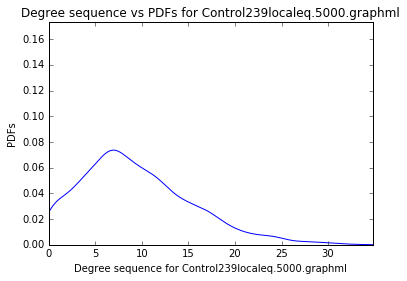

In [97]:
# Degree sequence
temp_deg = np.array(nx.degree(G).values())
deg = density(temp_deg)
# print deg
xs = deg['xs']
pdfs = deg['pdfs']

# Autoscale Output Image
pdfs = [i for i in pdfs if i >= 0.0001]
xs = xs[0: len(pdfs)]
xsMAX = np.amax(xs)
pdfsMAX = np.amax(pdfs)

# Plot File
plt.axis([0, xsMAX + 0.001, 0, pdfsMAX + 0.1])
plt.xlabel('Degree sequence for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Degree sequence vs PDFs for ' + filename)
fig1 = plt.plot(xs, pdfs)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'degreesequence.png', bbox_inches='tight')

# Make pickel
write('../pickels', 'degree sequence', deg, filename)

In [98]:
# Compute Edge Weight 
temp_ew = (G.get_edge_data(e[0], e[1])['weight'] for e in G.edges())
## ew = density(temp_ew) "ValueError: `dataset` input should have multiple elements."
print temp_ew
# We don't have edge weights so this makes sense

# Make pickel
# write('../pickels', 'edge weight', temp_ew, filename)

<generator object <genexpr> at 0x11372ea00>


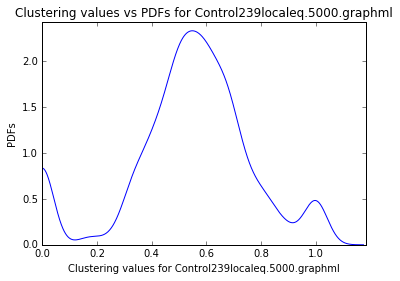

In [99]:
# Clustering Coefficients
nxc = nx.clustering 
temp_cc = nxc(G).values()
ccoefs = density(temp_cc)
xscc = ccoefs['xs']
pdfscc = ccoefs['pdfs']

# Autoscale Output Image
pdfscc = [i for i in pdfscc if i >= 0.0001]
xscc = xscc[0: len(pdfscc)]
xsccMAX = np.amax(xscc)
pdfsccMAX = np.amax(pdfscc)


# Plot File
plt.axis([0, xsccMAX + 0.01, 0, (pdfsccMAX + 0.1)])
plt.xlabel('Clustering values for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Clustering values vs PDFs for ' + filename)
fig2 = plt.plot(xscc, pdfscc)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename +'clusteringcoefficients.png', bbox_inches='tight')

# Make pickel
write('../pickels', 'clustering coefficient', ccoefs, filename)

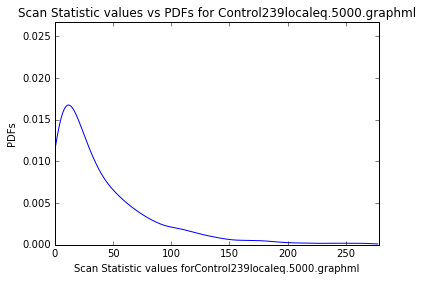

In [100]:
# Scan Statistic-1 
temp_ss1 = scan_statistic(G, 1)
ss1 = density(temp_ss1)

xsss = ss1['xs']
pdfsss = ss1['pdfs']

# Autoscale Output Image
pdfsss = [i for i in pdfsss if i >= 0.0001]
xsss = xsss[0: len(pdfsss)]
xsssMAX = np.amax(xsss)
pdfsssMAX = np.amax(pdfsss)

plt.axis([0, xsssMAX + 1, 0, pdfsssMAX + 0.01])
plt.xlabel('Scan Statistic values for' + filename)
plt.ylabel('PDFs')
plt.title(r'Scan Statistic values vs PDFs for ' + filename)
fig3 = plt.plot(xsss, pdfsss)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'scanstatistic.png')

# Make pickel
write('../pickels', 'scan statistic-1', ss1, filename)

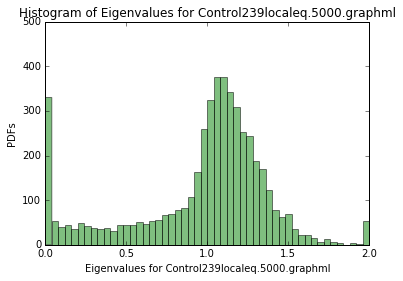

In [101]:
# EigenValues 
laplacian = nx.normalized_laplacian_matrix(G)
eigs = np.sort(np.linalg.eigvals(laplacian.A))[::-1]

num_bins = 50
# the histogram of the data
n, bins, patches = plt.hist(eigs, num_bins, facecolor='green', alpha=0.5)

plt.axis([0, 2, 0, 500])
plt.xlabel('Eigenvalues for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Histogram of Eigenvalues for ' + filename)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'eigenvalues.png')

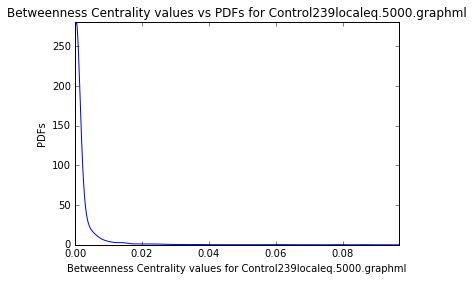

In [102]:
#Betweenness Centrality
nxbc = nx.algorithms.betweenness_centrality
temp_bc = (nxbc(G).values())
centrality = density(temp_bc)

xsbetween = centrality['xs']
pdfsbetween = centrality['pdfs']

# Autoscale Output Image
pdfsbetween = [i for i in pdfsbetween if i >= 0.0001]
xsbetween = xsbetween[0: len(pdfsbetween)]
xsbetweenMAX = np.amax(xsbetween)
pdfsbetweenMAX = np.amax(pdfsbetween)

# Plot
plt.axis([0, xsbetweenMAX, 0, pdfsbetweenMAX])
plt.xlabel('Betweenness Centrality values for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Betweenness Centrality values vs PDFs for ' + filename)
plt.plot(xsbetween, pdfsbetween)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'betweennesscentrality.png')

# Make pickel
write('../pickels', 'betweenness centrality', centrality, filename)

In [103]:
# Change the filename below to run different graphml files
filename = 'Control258localeq.5000.graphml'
G = nx.read_graphml(filename)

In [104]:
# NNZ - Number of non-zero edges
print len(nx.edges(G))
write('../pickels', 'non-zero_edges', nx.edges(G), filename)

18239


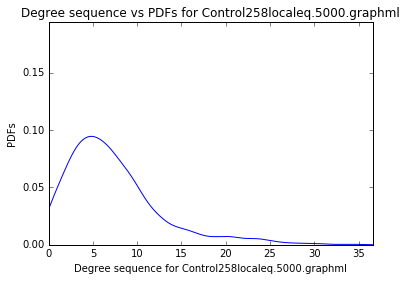

In [105]:
# Degree sequence
temp_deg = np.array(nx.degree(G).values())
deg = density(temp_deg)
# print deg
xs = deg['xs']
pdfs = deg['pdfs']

# Autoscale Output Image
pdfs = [i for i in pdfs if i >= 0.0001]
xs = xs[0: len(pdfs)]
xsMAX = np.amax(xs)
pdfsMAX = np.amax(pdfs)

# Plot File
plt.axis([0, xsMAX + 0.001, 0, pdfsMAX + 0.1])
plt.xlabel('Degree sequence for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Degree sequence vs PDFs for ' + filename)
fig1 = plt.plot(xs, pdfs)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'degreesequence.png', bbox_inches='tight')

# Make pickel
write('../pickels', 'degree sequence', deg, filename)

In [106]:
# Compute Edge Weight 
temp_ew = (G.get_edge_data(e[0], e[1])['weight'] for e in G.edges())
## ew = density(temp_ew) "ValueError: `dataset` input should have multiple elements."
print temp_ew
# We don't have edge weights so this makes sense

# Make pickel
# write('../pickels', 'edge weight', temp_ew, filename)

<generator object <genexpr> at 0x117926140>


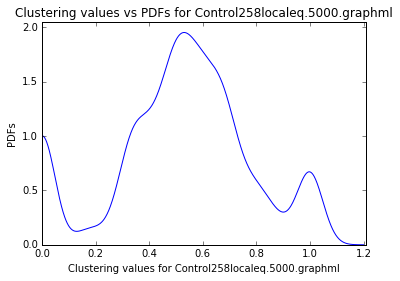

In [107]:
# Clustering Coefficients
nxc = nx.clustering 
temp_cc = nxc(G).values()
ccoefs = density(temp_cc)
xscc = ccoefs['xs']
pdfscc = ccoefs['pdfs']

# Autoscale Output Image
pdfscc = [i for i in pdfscc if i >= 0.0001]
xscc = xscc[0: len(pdfscc)]
xsccMAX = np.amax(xscc)
pdfsccMAX = np.amax(pdfscc)


# Plot File
plt.axis([0, xsccMAX + 0.01, 0, (pdfsccMAX + 0.1)])
plt.xlabel('Clustering values for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Clustering values vs PDFs for ' + filename)
fig2 = plt.plot(xscc, pdfscc)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename +'clusteringcoefficients.png', bbox_inches='tight')

# Make pickel
write('../pickels', 'clustering coefficient', ccoefs, filename)

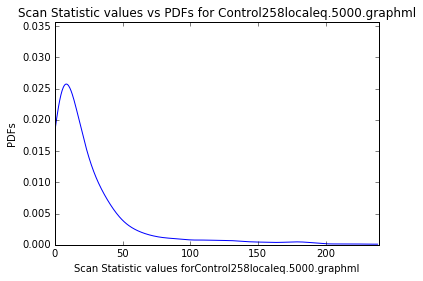

In [108]:
# Scan Statistic-1 
temp_ss1 = scan_statistic(G, 1)
ss1 = density(temp_ss1)

xsss = ss1['xs']
pdfsss = ss1['pdfs']

# Autoscale Output Image
pdfsss = [i for i in pdfsss if i >= 0.0001]
xsss = xsss[0: len(pdfsss)]
xsssMAX = np.amax(xsss)
pdfsssMAX = np.amax(pdfsss)

plt.axis([0, xsssMAX + 1, 0, pdfsssMAX + 0.01])
plt.xlabel('Scan Statistic values for' + filename)
plt.ylabel('PDFs')
plt.title(r'Scan Statistic values vs PDFs for ' + filename)
fig3 = plt.plot(xsss, pdfsss)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'scanstatistic.png')

# Make pickel
write('../pickels', 'scan statistic-1', ss1, filename)

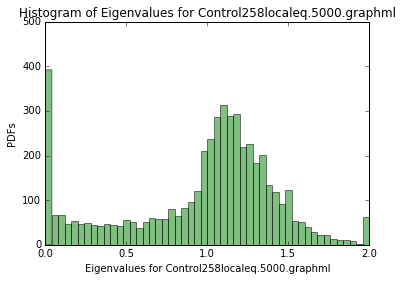

In [109]:
# EigenValues 
laplacian = nx.normalized_laplacian_matrix(G)
eigs = np.sort(np.linalg.eigvals(laplacian.A))[::-1]

num_bins = 50
# the histogram of the data
n, bins, patches = plt.hist(eigs, num_bins, facecolor='green', alpha=0.5)

plt.axis([0, 2, 0, 500])
plt.xlabel('Eigenvalues for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Histogram of Eigenvalues for ' + filename)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'eigenvalues.png')

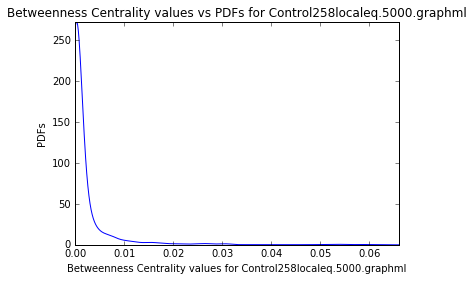

In [110]:
#Betweenness Centrality
nxbc = nx.algorithms.betweenness_centrality
temp_bc = (nxbc(G).values())
centrality = density(temp_bc)

xsbetween = centrality['xs']
pdfsbetween = centrality['pdfs']

# Autoscale Output Image
pdfsbetween = [i for i in pdfsbetween if i >= 0.0001]
xsbetween = xsbetween[0: len(pdfsbetween)]
xsbetweenMAX = np.amax(xsbetween)
pdfsbetweenMAX = np.amax(pdfsbetween)

# Plot
plt.axis([0, xsbetweenMAX, 0, pdfsbetweenMAX])
plt.xlabel('Betweenness Centrality values for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Betweenness Centrality values vs PDFs for ' + filename)
plt.plot(xsbetween, pdfsbetween)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'betweennesscentrality.png')

# Make pickel
write('../pickels', 'betweenness centrality', centrality, filename)

In [111]:
# Change the filename below to run different graphml files
filename = 'Fear187localeq.5000.graphml'
G = nx.read_graphml(filename)

In [112]:
# NNZ - Number of non-zero edges
print len(nx.edges(G))
write('../pickels', 'non-zero_edges', nx.edges(G), filename)

21675


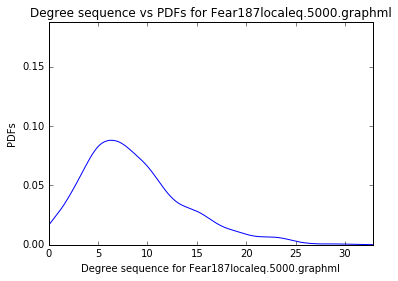

In [113]:
# Degree sequence
temp_deg = np.array(nx.degree(G).values())
deg = density(temp_deg)
# print deg
xs = deg['xs']
pdfs = deg['pdfs']

# Autoscale Output Image
pdfs = [i for i in pdfs if i >= 0.0001]
xs = xs[0: len(pdfs)]
xsMAX = np.amax(xs)
pdfsMAX = np.amax(pdfs)

# Plot File
plt.axis([0, xsMAX + 0.001, 0, pdfsMAX + 0.1])
plt.xlabel('Degree sequence for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Degree sequence vs PDFs for ' + filename)
fig1 = plt.plot(xs, pdfs)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'degreesequence.png', bbox_inches='tight')

# Make pickel
write('../pickels', 'degree sequence', deg, filename)

In [114]:
# Compute Edge Weight 
temp_ew = (G.get_edge_data(e[0], e[1])['weight'] for e in G.edges())
## ew = density(temp_ew) "ValueError: `dataset` input should have multiple elements."
print temp_ew
# We don't have edge weights so this makes sense

# Make pickel
# write('../pickels', 'edge weight', temp_ew, filename)

<generator object <genexpr> at 0x112143050>


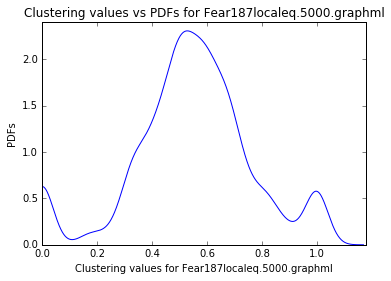

In [115]:
# Clustering Coefficients
nxc = nx.clustering 
temp_cc = nxc(G).values()
ccoefs = density(temp_cc)
xscc = ccoefs['xs']
pdfscc = ccoefs['pdfs']

# Autoscale Output Image
pdfscc = [i for i in pdfscc if i >= 0.0001]
xscc = xscc[0: len(pdfscc)]
xsccMAX = np.amax(xscc)
pdfsccMAX = np.amax(pdfscc)


# Plot File
plt.axis([0, xsccMAX + 0.01, 0, (pdfsccMAX + 0.1)])
plt.xlabel('Clustering values for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Clustering values vs PDFs for ' + filename)
fig2 = plt.plot(xscc, pdfscc)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename +'clusteringcoefficients.png', bbox_inches='tight')

# Make pickel
write('../pickels', 'clustering coefficient', ccoefs, filename)

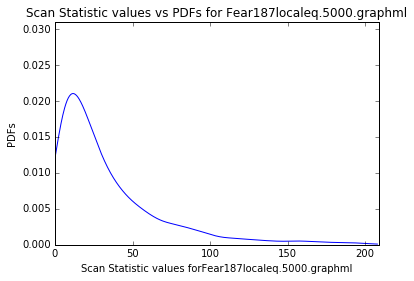

In [116]:
# Scan Statistic-1 
temp_ss1 = scan_statistic(G, 1)
ss1 = density(temp_ss1)

xsss = ss1['xs']
pdfsss = ss1['pdfs']

# Autoscale Output Image
pdfsss = [i for i in pdfsss if i >= 0.0001]
xsss = xsss[0: len(pdfsss)]
xsssMAX = np.amax(xsss)
pdfsssMAX = np.amax(pdfsss)

plt.axis([0, xsssMAX + 1, 0, pdfsssMAX + 0.01])
plt.xlabel('Scan Statistic values for' + filename)
plt.ylabel('PDFs')
plt.title(r'Scan Statistic values vs PDFs for ' + filename)
fig3 = plt.plot(xsss, pdfsss)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'scanstatistic.png')

# Make pickel
write('../pickels', 'scan statistic-1', ss1, filename)


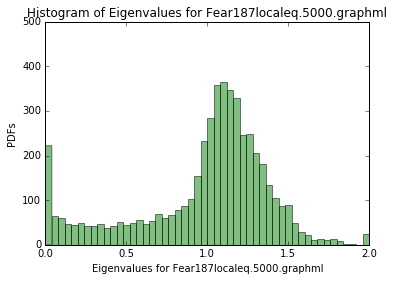

In [117]:
# EigenValues 
laplacian = nx.normalized_laplacian_matrix(G)
eigs = np.sort(np.linalg.eigvals(laplacian.A))[::-1]

num_bins = 50
# the histogram of the data
n, bins, patches = plt.hist(eigs, num_bins, facecolor='green', alpha=0.5)

plt.axis([0, 2, 0, 500])
plt.xlabel('Eigenvalues for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Histogram of Eigenvalues for ' + filename)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'eigenvalues.png')

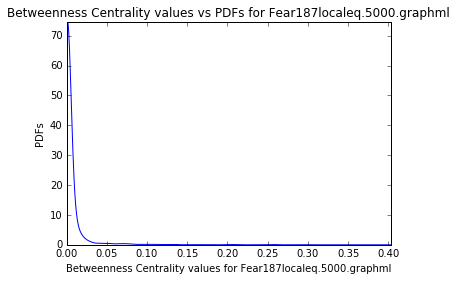

In [118]:
#Betweenness Centrality
nxbc = nx.algorithms.betweenness_centrality
temp_bc = (nxbc(G).values())
centrality = density(temp_bc)

xsbetween = centrality['xs']
pdfsbetween = centrality['pdfs']

# Autoscale Output Image
pdfsbetween = [i for i in pdfsbetween if i >= 0.0001]
xsbetween = xsbetween[0: len(pdfsbetween)]
xsbetweenMAX = np.amax(xsbetween)
pdfsbetweenMAX = np.amax(pdfsbetween)

# Plot
plt.axis([0, xsbetweenMAX, 0, pdfsbetweenMAX])
plt.xlabel('Betweenness Centrality values for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Betweenness Centrality values vs PDFs for ' + filename)
plt.plot(xsbetween, pdfsbetween)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'betweennesscentrality.png')

# Make pickel
write('../pickels', 'betweenness centrality', centrality, filename)

In [119]:
# Change the filename below to run different graphml files
filename = 'Fear197localeq.5000.graphml'
G = nx.read_graphml(filename)

In [120]:
# NNZ - Number of non-zero edges
print len(nx.edges(G))
write('../pickels', 'non-zero_edges', nx.edges(G), filename)

17364


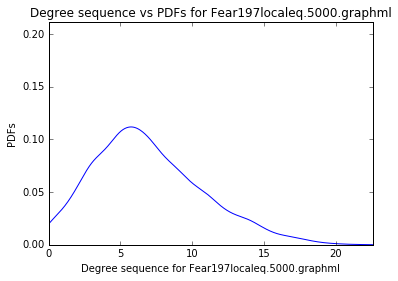

In [121]:
# Degree sequence
temp_deg = np.array(nx.degree(G).values())
deg = density(temp_deg)
# print deg
xs = deg['xs']
pdfs = deg['pdfs']

# Autoscale Output Image
pdfs = [i for i in pdfs if i >= 0.0001]
xs = xs[0: len(pdfs)]
xsMAX = np.amax(xs)
pdfsMAX = np.amax(pdfs)

# Plot File
plt.axis([0, xsMAX + 0.001, 0, pdfsMAX + 0.1])
plt.xlabel('Degree sequence for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Degree sequence vs PDFs for ' + filename)
fig1 = plt.plot(xs, pdfs)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'degreesequence.png', bbox_inches='tight')

# Make pickel
write('../pickels', 'degree sequence', deg, filename)

In [122]:
# Compute Edge Weight 
temp_ew = (G.get_edge_data(e[0], e[1])['weight'] for e in G.edges())
## ew = density(temp_ew) "ValueError: `dataset` input should have multiple elements."
print temp_ew
# We don't have edge weights so this makes sense

# Make pickel
# write('../pickels', 'edge weight', temp_ew, filename)

<generator object <genexpr> at 0x1199a4410>


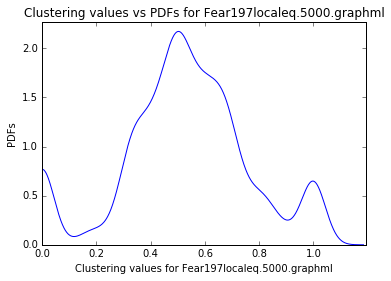

In [123]:
# Clustering Coefficients
nxc = nx.clustering 
temp_cc = nxc(G).values()
ccoefs = density(temp_cc)
xscc = ccoefs['xs']
pdfscc = ccoefs['pdfs']

# Autoscale Output Image
pdfscc = [i for i in pdfscc if i >= 0.0001]
xscc = xscc[0: len(pdfscc)]
xsccMAX = np.amax(xscc)
pdfsccMAX = np.amax(pdfscc)


# Plot File
plt.axis([0, xsccMAX + 0.01, 0, (pdfsccMAX + 0.1)])
plt.xlabel('Clustering values for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Clustering values vs PDFs for ' + filename)
fig2 = plt.plot(xscc, pdfscc)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename +'clusteringcoefficients.png', bbox_inches='tight')

# Make pickel
write('../pickels', 'clustering coefficient', ccoefs, filename)

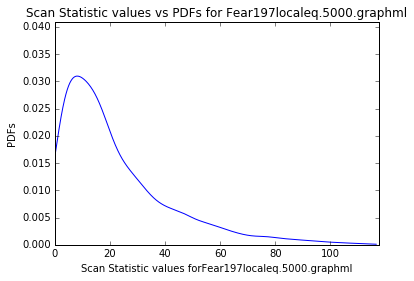

In [124]:
# Scan Statistic-1 
temp_ss1 = scan_statistic(G, 1)
ss1 = density(temp_ss1)

xsss = ss1['xs']
pdfsss = ss1['pdfs']

# Autoscale Output Image
pdfsss = [i for i in pdfsss if i >= 0.0001]
xsss = xsss[0: len(pdfsss)]
xsssMAX = np.amax(xsss)
pdfsssMAX = np.amax(pdfsss)

plt.axis([0, xsssMAX + 1, 0, pdfsssMAX + 0.01])
plt.xlabel('Scan Statistic values for' + filename)
plt.ylabel('PDFs')
plt.title(r'Scan Statistic values vs PDFs for ' + filename)
fig3 = plt.plot(xsss, pdfsss)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'scanstatistic.png')

# Make pickel
write('../pickels', 'scan statistic-1', ss1, filename)

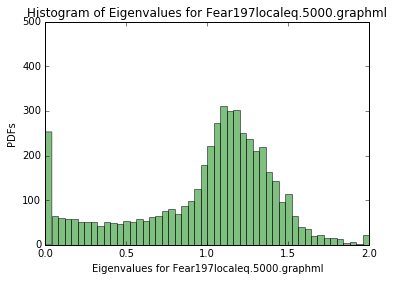

In [125]:
# EigenValues 
laplacian = nx.normalized_laplacian_matrix(G)
eigs = np.sort(np.linalg.eigvals(laplacian.A))[::-1]

num_bins = 50
# the histogram of the data
n, bins, patches = plt.hist(eigs, num_bins, facecolor='green', alpha=0.5)

plt.axis([0, 2, 0, 500])
plt.xlabel('Eigenvalues for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Histogram of Eigenvalues for ' + filename)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'eigenvalues.png')

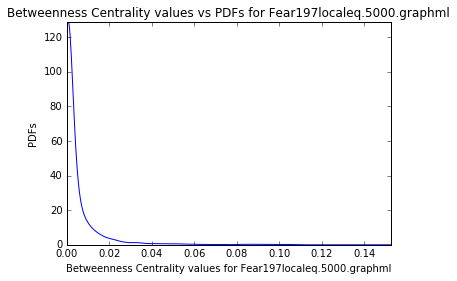

In [126]:
#Betweenness Centrality
nxbc = nx.algorithms.betweenness_centrality
temp_bc = (nxbc(G).values())
centrality = density(temp_bc)

xsbetween = centrality['xs']
pdfsbetween = centrality['pdfs']

# Autoscale Output Image
pdfsbetween = [i for i in pdfsbetween if i >= 0.0001]
xsbetween = xsbetween[0: len(pdfsbetween)]
xsbetweenMAX = np.amax(xsbetween)
pdfsbetweenMAX = np.amax(pdfsbetween)

# Plot
plt.axis([0, xsbetweenMAX, 0, pdfsbetweenMAX])
plt.xlabel('Betweenness Centrality values for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Betweenness Centrality values vs PDFs for ' + filename)
plt.plot(xsbetween, pdfsbetween)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'betweennesscentrality.png')

# Make pickel
write('../pickels', 'betweenness centrality', centrality, filename)

In [127]:
# Change the filename below to run different graphml files
filename = 'Fear200localeq.5000.graphml'
G = nx.read_graphml(filename)

In [128]:
# NNZ - Number of non-zero edges
print len(nx.edges(G))
write('../pickels', 'non-zero_edges', nx.edges(G), filename)

21823


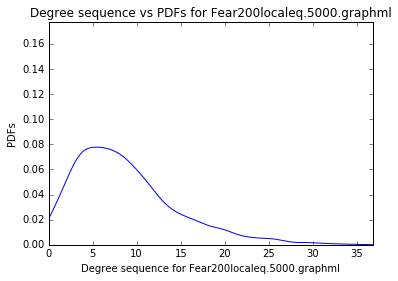

In [129]:
# Degree sequence
temp_deg = np.array(nx.degree(G).values())
deg = density(temp_deg)
# print deg
xs = deg['xs']
pdfs = deg['pdfs']

# Autoscale Output Image
pdfs = [i for i in pdfs if i >= 0.0001]
xs = xs[0: len(pdfs)]
xsMAX = np.amax(xs)
pdfsMAX = np.amax(pdfs)

# Plot File
plt.axis([0, xsMAX + 0.001, 0, pdfsMAX + 0.1])
plt.xlabel('Degree sequence for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Degree sequence vs PDFs for ' + filename)
fig1 = plt.plot(xs, pdfs)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'degreesequence.png', bbox_inches='tight')

# Make pickel
write('../pickels', 'degree sequence', deg, filename)

In [130]:
# Compute Edge Weight 
temp_ew = (G.get_edge_data(e[0], e[1])['weight'] for e in G.edges())
## ew = density(temp_ew) "ValueError: `dataset` input should have multiple elements."
print temp_ew
# We don't have edge weights so this makes sense

# Make pickel
# write('../pickels', 'edge weight', temp_ew, filename)

<generator object <genexpr> at 0x1199bea50>


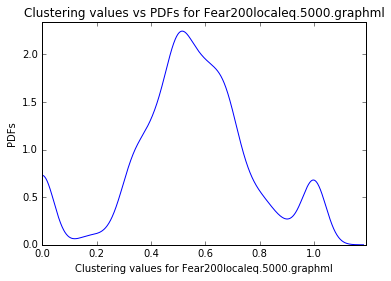

In [131]:
# Clustering Coefficients
nxc = nx.clustering 
temp_cc = nxc(G).values()
ccoefs = density(temp_cc)
xscc = ccoefs['xs']
pdfscc = ccoefs['pdfs']

# Autoscale Output Image
pdfscc = [i for i in pdfscc if i >= 0.0001]
xscc = xscc[0: len(pdfscc)]
xsccMAX = np.amax(xscc)
pdfsccMAX = np.amax(pdfscc)


# Plot File
plt.axis([0, xsccMAX + 0.01, 0, (pdfsccMAX + 0.1)])
plt.xlabel('Clustering values for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Clustering values vs PDFs for ' + filename)
fig2 = plt.plot(xscc, pdfscc)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename +'clusteringcoefficients.png', bbox_inches='tight')

# Make pickel
write('../pickels', 'clustering coefficient', ccoefs, filename)

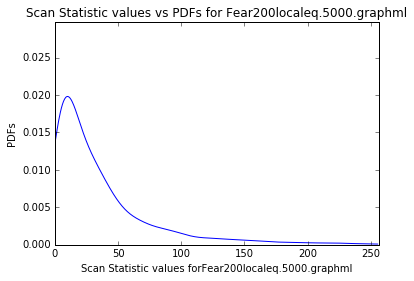

In [132]:
# Scan Statistic-1 
temp_ss1 = scan_statistic(G, 1)
ss1 = density(temp_ss1)

xsss = ss1['xs']
pdfsss = ss1['pdfs']

# Autoscale Output Image
pdfsss = [i for i in pdfsss if i >= 0.0001]
xsss = xsss[0: len(pdfsss)]
xsssMAX = np.amax(xsss)
pdfsssMAX = np.amax(pdfsss)

plt.axis([0, xsssMAX + 1, 0, pdfsssMAX + 0.01])
plt.xlabel('Scan Statistic values for' + filename)
plt.ylabel('PDFs')
plt.title(r'Scan Statistic values vs PDFs for ' + filename)
fig3 = plt.plot(xsss, pdfsss)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'scanstatistic.png')

# Make pickel
write('../pickels', 'scan statistic-1', ss1, filename)

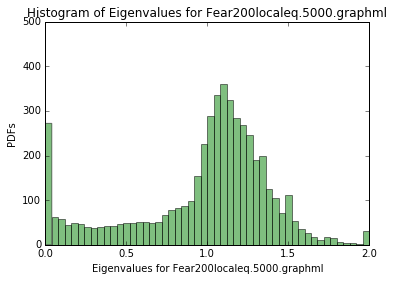

In [133]:
# EigenValues 
laplacian = nx.normalized_laplacian_matrix(G)
eigs = np.sort(np.linalg.eigvals(laplacian.A))[::-1]

num_bins = 50
# the histogram of the data
n, bins, patches = plt.hist(eigs, num_bins, facecolor='green', alpha=0.5)

plt.axis([0, 2, 0, 500])
plt.xlabel('Eigenvalues for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Histogram of Eigenvalues for ' + filename)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'eigenvalues.png')

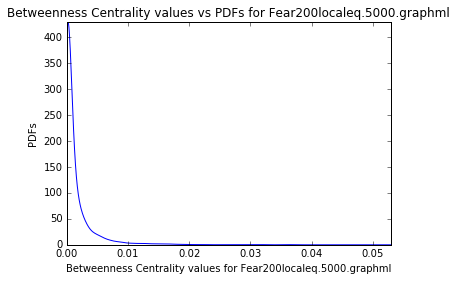

In [134]:
#Betweenness Centrality
nxbc = nx.algorithms.betweenness_centrality
temp_bc = (nxbc(G).values())
centrality = density(temp_bc)

xsbetween = centrality['xs']
pdfsbetween = centrality['pdfs']

# Autoscale Output Image
pdfsbetween = [i for i in pdfsbetween if i >= 0.0001]
xsbetween = xsbetween[0: len(pdfsbetween)]
xsbetweenMAX = np.amax(xsbetween)
pdfsbetweenMAX = np.amax(pdfsbetween)

# Plot
plt.axis([0, xsbetweenMAX, 0, pdfsbetweenMAX])
plt.xlabel('Betweenness Centrality values for ' + filename)
plt.ylabel('PDFs')
plt.title(r'Betweenness Centrality values vs PDFs for ' + filename)
plt.plot(xsbetween, pdfsbetween)

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(filename + 'betweennesscentrality.png')

# Make pickel
write('../pickels', 'betweenness centrality', centrality, filename)